## NN Classification on previous datasets

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
def _prepare_binary_inputs(y_true, y_pred, threshold):
    """Utility to flatten sparse labels and extract positive-class probabilities."""
    y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred = tf.cast(tf.convert_to_tensor(y_pred), tf.float32)
    if y_pred.shape.rank is not None:
        if y_pred.shape.rank > 1:
            if y_pred.shape[-1] == 1:
                y_pred = tf.squeeze(y_pred, axis=-1)
            else:
                y_pred = y_pred[..., 1]
        else:
            y_pred = tf.reshape(y_pred, [-1])
    else:
        rank = tf.rank(y_pred)
        y_pred = tf.cond(
            tf.equal(rank, 1),
            lambda: tf.reshape(y_pred, [-1]),
            lambda: tf.cond(
                tf.equal(tf.shape(y_pred)[-1], 1),
                lambda: tf.squeeze(y_pred, axis=-1),
                lambda: y_pred[..., 1]
            )
        )
    y_pred = tf.reshape(y_pred, [-1])
    y_pred_labels = tf.cast(y_pred >= threshold, tf.float32)
    return y_true, y_pred, y_pred_labels


class BinaryPrecision(tf.keras.metrics.Metric):
    """Binary precision that treats class 1 as the positive class."""
    def __init__(self, name='precision', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='true_positives', initializer='zeros')
        self.fp = self.add_weight(name='false_positives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true, _, y_pred_labels = _prepare_binary_inputs(y_true, y_pred, self.threshold)
        if sample_weight is not None:
            sample_weight = tf.cast(tf.reshape(sample_weight, [-1]), tf.float32)
        else:
            sample_weight = tf.ones_like(y_true)
        tp = tf.reduce_sum(sample_weight * y_true * y_pred_labels)
        fp = tf.reduce_sum(sample_weight * (1.0 - y_true) * y_pred_labels)
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)

    def result(self):
        denom = self.tp + self.fp
        return tf.where(tf.equal(denom, 0.0), 0.0, self.tp / denom)

    def reset_state(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)


class BinaryRecall(tf.keras.metrics.Metric):
    """Binary recall that treats class 1 as the positive class."""
    def __init__(self, name='recall', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='true_positives', initializer='zeros')
        self.fn = self.add_weight(name='false_negatives', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true, _, y_pred_labels = _prepare_binary_inputs(y_true, y_pred, self.threshold)
        if sample_weight is not None:
            sample_weight = tf.cast(tf.reshape(sample_weight, [-1]), tf.float32)
        else:
            sample_weight = tf.ones_like(y_true)
        tp = tf.reduce_sum(sample_weight * y_true * y_pred_labels)
        fn = tf.reduce_sum(sample_weight * y_true * (1.0 - y_pred_labels))
        self.tp.assign_add(tp)
        self.fn.assign_add(fn)

    def result(self):
        denom = self.tp + self.fn
        return tf.where(tf.equal(denom, 0.0), 0.0, self.tp / denom)

    def reset_state(self):
        self.tp.assign(0.0)
        self.fn.assign(0.0)


class BinaryF1Score(tf.keras.metrics.Metric):
    """Binary F1 score metric that treats class 1 as the positive class."""
    def __init__(self, name='f1', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision_metric = BinaryPrecision(name='precision_component', threshold=threshold)
        self.recall_metric = BinaryRecall(name='recall_component', threshold=threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision_metric.update_state(y_true, y_pred, sample_weight)
        self.recall_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision_metric.result()
        recall = self.recall_metric.result()
        denom = precision + recall
        return tf.where(tf.equal(denom, 0.0), 0.0, 2.0 * precision * recall / denom)

    def reset_state(self):
        self.precision_metric.reset_state()
        self.recall_metric.reset_state()

In [3]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True, show_confusion_matrix=True):
    val_losses = hist.history['val_loss']
    min_val_loss = float(np.min(val_losses))
    min_val_epoch = int(np.argmin(val_losses)) + 1

    train_precision = hist.history.get('precision')
    val_precision = hist.history.get('val_precision')
    train_recall = hist.history.get('recall')
    val_recall = hist.history.get('val_recall')
    train_f1 = hist.history.get('f1')
    val_f1 = hist.history.get('val_f1')
    train_accuracy = hist.history.get('accuracy')
    val_accuracy = hist.history.get('val_accuracy')

    required = [train_precision, val_precision, train_recall, val_recall, train_f1, val_f1, train_accuracy, val_accuracy]
    if any(metric_series is None for metric_series in required):
        raise ValueError("Expected precision, recall, f1, and accuracy metrics in training history. Ensure the model is compiled with these metrics.")

    best_val_recall = float(np.max(val_recall))
    best_val_recall_epoch = int(np.argmax(val_recall)) + 1
    best_val_precision = float(np.max(val_precision))
    best_val_precision_epoch = int(np.argmax(val_precision)) + 1
    best_val_f1 = float(np.max(val_f1))
    best_val_f1_epoch = int(np.argmax(val_f1)) + 1
    best_val_accuracy = float(np.max(val_accuracy))
    best_val_accuracy_epoch = int(np.argmax(val_accuracy)) + 1

    val_recall_at_min_loss = float(val_recall[min_val_epoch - 1])
    val_precision_at_min_loss = float(val_precision[min_val_epoch - 1])
    val_f1_at_min_loss = float(val_f1[min_val_epoch - 1])
    val_accuracy_at_min_loss = float(val_accuracy[min_val_epoch - 1])

    epochs = range(1, len(val_losses) + 1)

    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, val_losses, label='val loss')
    axs[0].scatter(min_val_epoch, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Recall Plot ---
    axs[1].plot(epochs, train_recall, label='train recall')
    axs[1].plot(epochs, val_recall, label='val recall')
    axs[1].scatter(best_val_recall_epoch, best_val_recall, color='green', marker='x', s=50, label='max val recall')
    axs[1].set_title(f'{title} - Recall')
    axs[1].set_ylabel('Recall')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    # --- Precision / Accuracy / F1 Plot ---
    axs[2].plot(epochs, train_precision, label='train precision', linestyle='--')
    axs[2].plot(epochs, val_precision, label='val precision')
    axs[2].plot(epochs, train_f1, label='train f1', linestyle='--')
    axs[2].plot(epochs, val_f1, label='val f1')
    axs[2].plot(epochs, train_accuracy, label='train accuracy', linestyle='--')
    axs[2].plot(epochs, val_accuracy, label='val accuracy')
    axs[2].set_title(f'{title} - Precision / F1 / Accuracy')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Score')
    axs[2].legend(ncol=2)
    axs[2].grid(True)
    axs[2].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if show_confusion_matrix:
        print("\nConfusion Matrix (Validation Set)")
        print("----------------------------------")
        try:
            val_probs = model.predict(X_val)
            if val_probs.ndim == 1 or val_probs.shape[-1] == 1:
                val_preds = (val_probs >= 0.5).astype(int).ravel()
            else:
                val_preds = np.argmax(val_probs, axis=1)
            cm = confusion_matrix(y_true=y_val, y_pred=val_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(cmap=plt.cm.Blues)
            disp.ax_.set_xlabel('Predicted Label')
            disp.ax_.set_ylabel('True Label')
            disp.ax_.set_title(f'{title} - Confusion Matrix (Validation)')
            plt.show()
        except Exception as ex:
            print("Confusion matrix could not be generated:")
            print(ex)

    if verbose:
        print(f"Final Training Metrics -> Loss: {hist.history['loss'][-1]:.4f}, Precision: {train_precision[-1]:.4f}, Recall: {train_recall[-1]:.4f}, F1: {train_f1[-1]:.4f}, Accuracy: {train_accuracy[-1]:.4f}")
        print(f"Final Validation Metrics -> Loss: {val_losses[-1]:.4f}, Precision: {val_precision[-1]:.4f}, Recall: {val_recall[-1]:.4f}, F1: {val_f1[-1]:.4f}, Accuracy: {val_accuracy[-1]:.4f}")
        print(f"Minimum Validation Loss: {min_val_loss:.4f} (Epoch {min_val_epoch})")
        print(f"Validation Metrics @ Min Loss -> Precision: {val_precision_at_min_loss:.4f}, Recall: {val_recall_at_min_loss:.4f}, F1: {val_f1_at_min_loss:.4f}, Accuracy: {val_accuracy_at_min_loss:.4f}")
        print(f"Best Validation Recall: {best_val_recall:.4f} (Epoch {best_val_recall_epoch})")
        print(f"Best Validation Precision: {best_val_precision:.4f} (Epoch {best_val_precision_epoch})")
        print(f"Best Validation F1: {best_val_f1:.4f} (Epoch {best_val_f1_epoch})")
        print(f"Best Validation Accuracy: {best_val_accuracy:.4f} (Epoch {best_val_accuracy_epoch})")

    results[title] = (best_val_recall, best_val_recall_epoch)

    return {
        'min_val_loss': min_val_loss,
        'min_val_epoch': min_val_epoch,
        'val_precision_at_min_loss': val_precision_at_min_loss,
        'val_recall_at_min_loss': val_recall_at_min_loss,
        'val_f1_at_min_loss': val_f1_at_min_loss,
        'val_accuracy_at_min_loss': val_accuracy_at_min_loss,
        'best_val_precision': best_val_precision,
        'best_val_precision_epoch': best_val_precision_epoch,
        'best_val_recall': best_val_recall,
        'best_val_recall_epoch': best_val_recall_epoch,
        'best_val_f1': best_val_f1,
        'best_val_f1_epoch': best_val_f1_epoch,
        'best_val_accuracy': best_val_accuracy,
        'best_val_accuracy_epoch': best_val_accuracy_epoch
    }

results = {}

In [4]:
def print_results():
    for title, (recall_val, epoch) in sorted(results.items(),
                                             key=lambda kv: kv[1][0],
                                             reverse=True):
        print(f"{title:<40}\tBest Val Recall: {recall_val:.4f} (Epoch {epoch})")

In [5]:
# Uses globals X_train,y_train,X_val,y_val
def train_and_test(model,
                   epochs        = 500,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")

    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    metrics_to_track = [
        BinaryPrecision(name='precision'),
        BinaryRecall(name='recall'),
        BinaryF1Score(name='f1'),
        'accuracy'
    ]

    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=metrics_to_track
                 )

    early_stop = EarlyStopping(
        monitor='val_recall',
        patience=patience,
        min_delta=min_delta,
        mode='max',
        restore_best_weights=True,
        verbose=verbose
    )

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )

    class_weights_dict = dict(enumerate(class_weights))

    if use_early_stopping:
        cbs = [early_stop] + callbacks
    else:
        cbs = callbacks

    start = time.time()

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        class_weight=class_weights_dict,
                        callbacks=cbs,
                        verbose=verbose
                       )

    curve_summary = plot_learning_curves(history, title=title)

    final_train_precision = float(history.history['precision'][-1])
    final_train_recall = float(history.history['recall'][-1])
    final_train_f1 = float(history.history['f1'][-1])
    final_train_accuracy = float(history.history['accuracy'][-1])

    final_val_precision = float(history.history['val_precision'][-1])
    final_val_recall = float(history.history['val_recall'][-1])
    final_val_f1 = float(history.history['val_f1'][-1])
    final_val_accuracy = float(history.history['val_accuracy'][-1])

    eval_results = model.evaluate(X_test, y_test, verbose=0)
    test_loss = float(eval_results[0])
    test_precision = float(eval_results[1])
    test_recall = float(eval_results[2])
    test_f1 = float(eval_results[3])
    test_accuracy = float(eval_results[4])

    print(f"\nTest Metrics -> Loss: {test_loss:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, Accuracy: {test_accuracy:.4f}")

    validation_test_gap_recall = abs(curve_summary['best_val_recall'] - test_recall)
    validation_test_gap_precision = abs(curve_summary['best_val_precision'] - test_precision)
    validation_test_gap_f1 = abs(curve_summary['best_val_f1'] - test_f1)
    validation_test_gap_accuracy = abs(curve_summary['best_val_accuracy'] - test_accuracy)

    print(f"\nValidation-Test Gap -> Recall: {validation_test_gap_recall:.6f}, Precision: {validation_test_gap_precision:.6f}, F1: {validation_test_gap_f1:.6f}, Accuracy: {validation_test_gap_accuracy:.6f}")

    end = time.time()
    print(f"\nExecution Time: " + format_hms(end - start))

    metrics = {
        **curve_summary,
        'final_train_precision': final_train_precision,
        'final_train_recall': final_train_recall,
        'final_train_f1': final_train_f1,
        'final_train_accuracy': final_train_accuracy,
        'final_val_precision': final_val_precision,
        'final_val_recall': final_val_recall,
        'final_val_f1': final_val_f1,
        'final_val_accuracy': final_val_accuracy,
        'test_loss': test_loss,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_accuracy': test_accuracy,
        'validation_test_gap_recall': validation_test_gap_recall,
        'validation_test_gap_precision': validation_test_gap_precision,
        'validation_test_gap_f1': validation_test_gap_f1,
        'validation_test_gap_accuracy': validation_test_gap_accuracy
    }

    if return_history:
        return history, metrics

    return metrics

In [6]:
def encoding(df_or_series, target=None, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        target: Column name (or iterable of names) to leave untouched when encoding a DataFrame.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: encoded DataFrame (and optionally mappings for label encoding).
        If input is Series: encoded Series.
    """
    # Normalize target parameter into a set for quick exclusion checks
    if target is None:
        target_cols = set()
    elif isinstance(target, (list, tuple, set)):
        target_cols = set(target)
    else:
        target_cols = {target}

    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded

    elif isinstance(df_or_series, pd.DataFrame):
        df_encoded = df_or_series.copy()

        if one_hot:
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            cat_cols = [c for c in cat_cols if c not in target_cols]
            return pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)

        if cat_cols is None:
            cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
        cat_cols = [c for c in cat_cols if c not in target_cols]

        mappings = {}
        for col in cat_cols:
            uniques = df_encoded[col].dropna().unique().tolist()
            mapping = {cat: code for code, cat in enumerate(uniques)}
            mappings[col] = mapping
            df_encoded[col] = df_encoded[col].map(mapping).astype("int64")

        return df_encoded

    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [7]:
def split_data(df: pd.DataFrame, 
                        target_col: str = None, 
                        one_hot: bool = False, 
                        test_size: float = 0.2, 
                        random_state: int = 0, 
                        scaling: str = 'norm'
                        ):
    """
    Loads data, encodes categorical features, splits into train/test, and scales features.

    Args:
        file_path: Path to CSV file.
        target_col: Name of target column. If None, uses last column.
        test_size: Fraction for test split.
        random_state: Random seed.
        scaling: 'norm' (MinMax), 'reg' (Standard), or None.

    Returns:
        X_train, X_test, y_train, y_test, df, mappings
    """

    # Select target
    if target_col is None:
        target_col = df.columns[-1]
    X = df.drop(columns=[target_col])
    y = df[target_col]
        
    # stratified 60/20/20 split (train/val/test)
    test_size = 0.20
    val_size = 0.20  # of the whole dataset

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_seed, stratify=y
    )
    val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
    )

    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Scaling
    if scaling == 'reg':
        scaler = StandardScaler()
    elif scaling == 'norm':
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # quick sanity checks
    def show_counts(name, y_arr):
        c = Counter(y_arr)
        total = sum(c.values())
        print(f"{name}: total={total}, per-class={dict(c)}")

    print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
    show_counts("train", y_train)
    show_counts("val  ", y_val)
    show_counts("test ", y_test)

    # you now have: X_train, y_train, X_val, y_val, X_test, y_test

    # Looks like integer encoded multi-class, let's check and define the global n_classes

    labels = np.unique(y_train)

    n_classes = len(labels)

    print("class labels:",labels)

    return X_train, X_val, X_test, y_train, y_val, y_test, df, n_classes


In [8]:
# Load the cleaned datasets
df_car = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\carclaims_cleaned.csv')

# Encode the datasets
df_car_oh = encoding(df_car, one_hot=True)

# Regularized One-hot data
X_train, X_val, X_test, y_train, y_val, y_test, df_car, n_classes = split_data(df_car_oh, target_col='FraudFound', scaling='reg')

shapes: X_train (9060, 113) X_val (3020, 113) X_test (3020, 113)
train: total=9060, per-class={0: 8524, 1: 536}
val  : total=3020, per-class={0: 2842, 1: 178}
test : total=3020, per-class={0: 2842, 1: 178}
class labels: [0 1]


In [9]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
    )

class_weights_dict = dict(enumerate(class_weights))

In [10]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )

In [11]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,442 (36.88 KB)

 Trainable params: 9,442 (36.88 KB)

 Non-trainable params: 0 (0.00 B)

### Activation Function testing


Activation Function: relu



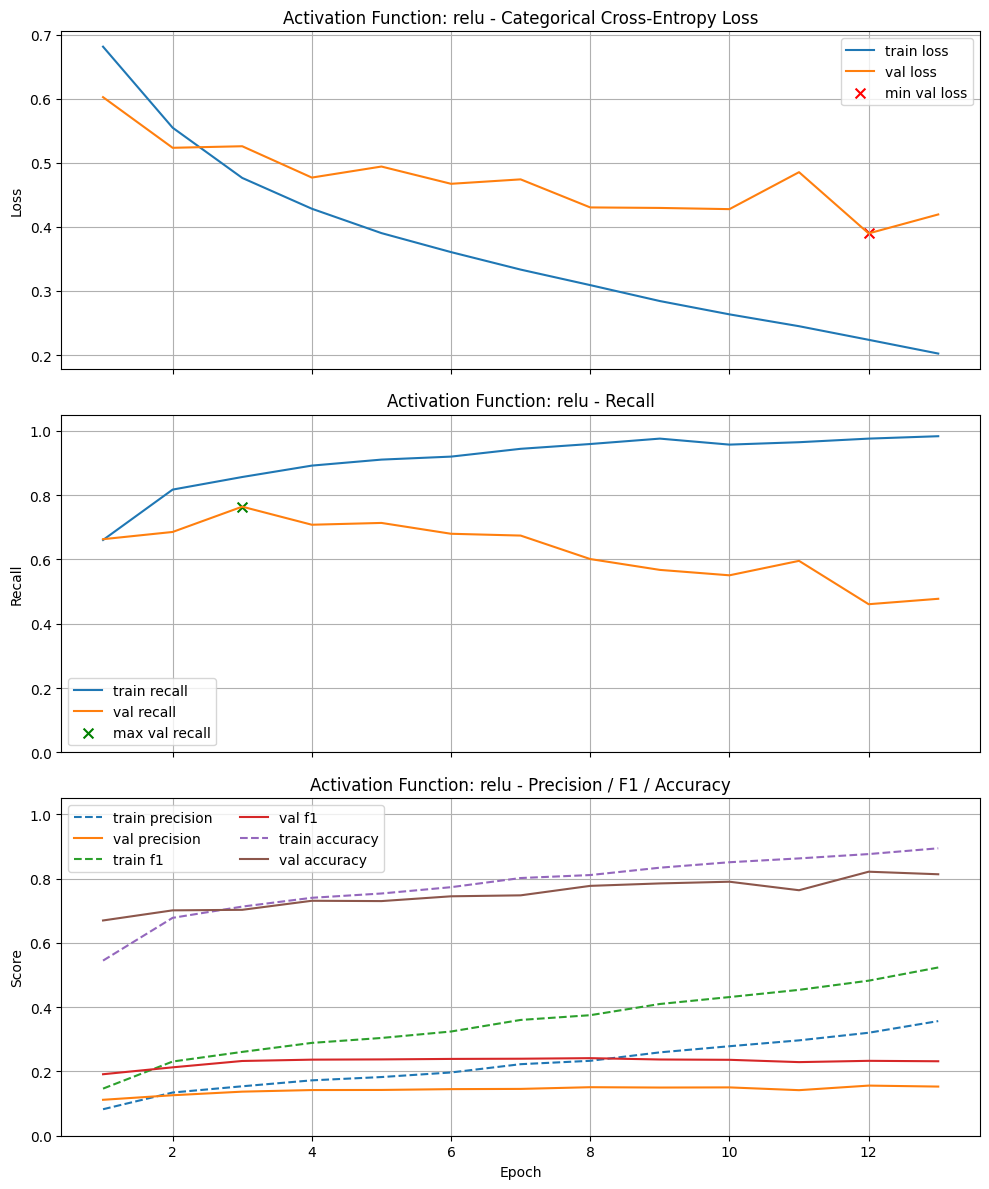


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


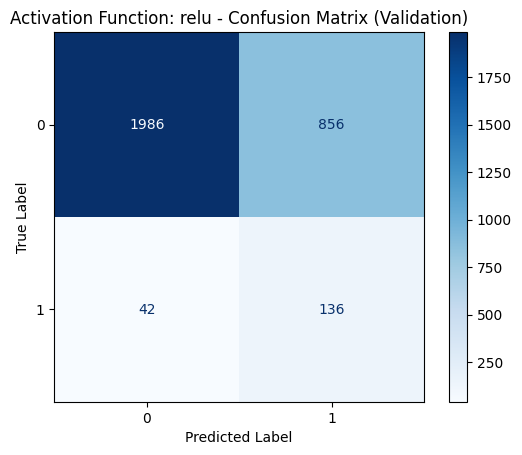

Final Training Metrics -> Loss: 0.2023, Precision: 0.3566, Recall: 0.9832, F1: 0.5233, Accuracy: 0.8940
Final Validation Metrics -> Loss: 0.4193, Precision: 0.1529, Recall: 0.4775, F1: 0.2316, Accuracy: 0.8132
Minimum Validation Loss: 0.3897 (Epoch 12)
Validation Metrics @ Min Loss -> Precision: 0.1559, Recall: 0.4607, F1: 0.2330, Accuracy: 0.8212
Best Validation Recall: 0.7640 (Epoch 3)
Best Validation Precision: 0.1559 (Epoch 12)
Best Validation F1: 0.2413 (Epoch 8)
Best Validation Accuracy: 0.8212 (Epoch 12)

Test Metrics -> Loss: 0.5284, Precision: 0.1303, Recall: 0.7360, F1: 0.2215, Accuracy: 0.6950

Validation-Test Gap -> Recall: 0.028090, Precision: 0.025545, F1: 0.019792, Accuracy: 0.126159

Execution Time: 00:00:04

Activation Function: tanh


Test Metrics -> Loss: 0.5284, Precision: 0.1303, Recall: 0.7360, F1: 0.2215, Accuracy: 0.6950

Validation-Test Gap -> Recall: 0.028090, Precision: 0.025545, F1: 0.019792, Accuracy: 0.126159

Execution Time: 00:00:04

Activation Function:

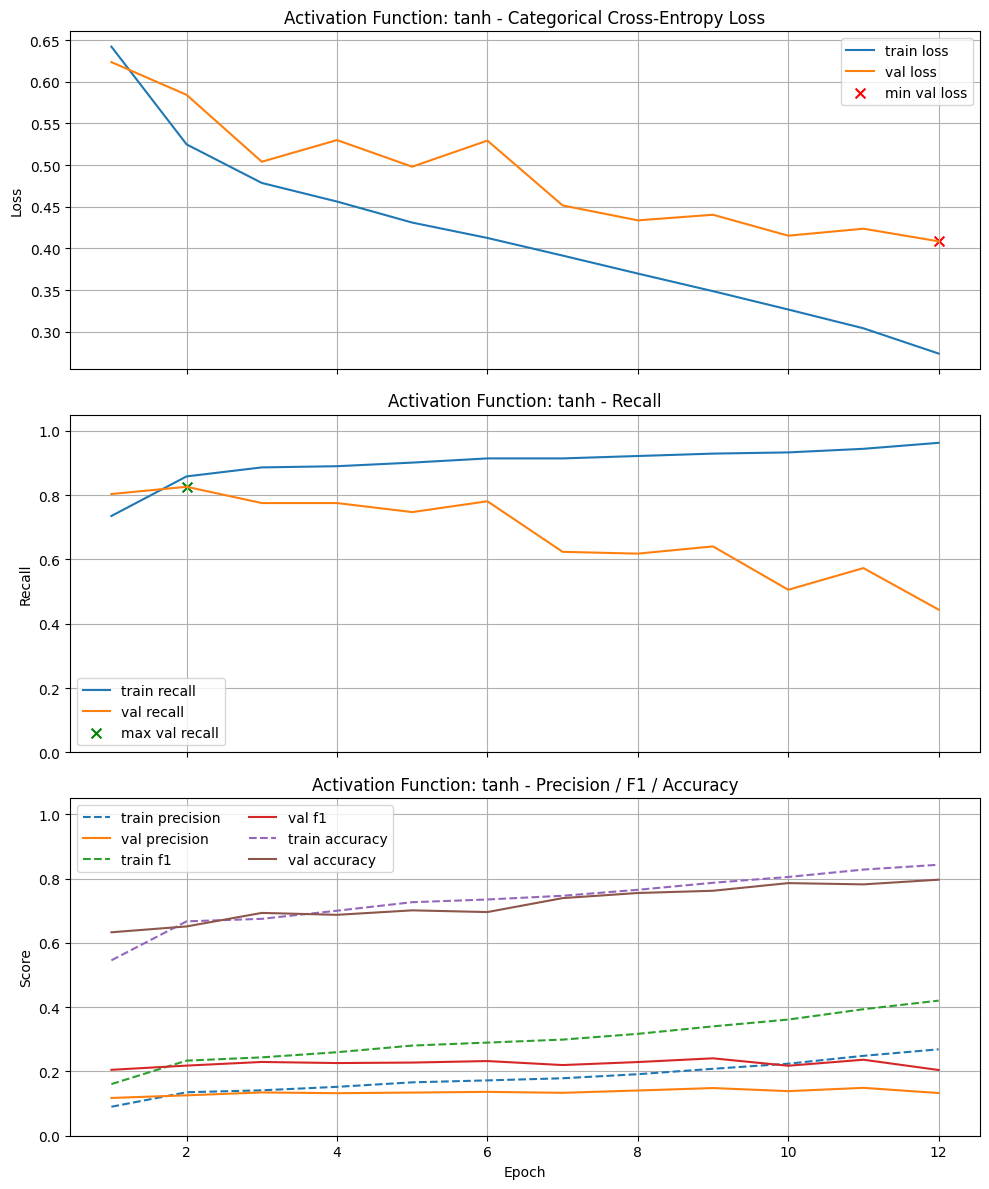


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


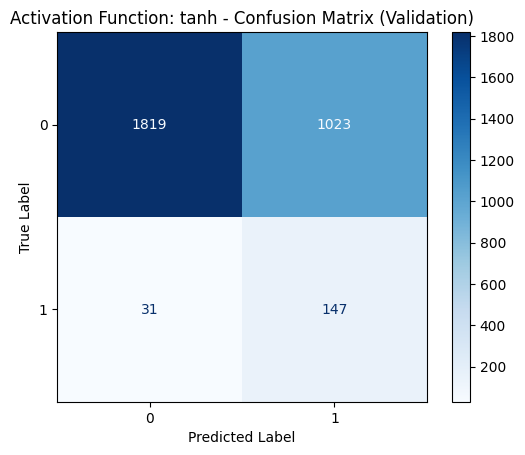

Final Training Metrics -> Loss: 0.2738, Precision: 0.2688, Recall: 0.9627, F1: 0.4202, Accuracy: 0.8428
Final Validation Metrics -> Loss: 0.4085, Precision: 0.1328, Recall: 0.4438, F1: 0.2044, Accuracy: 0.7964
Minimum Validation Loss: 0.4085 (Epoch 12)
Validation Metrics @ Min Loss -> Precision: 0.1328, Recall: 0.4438, F1: 0.2044, Accuracy: 0.7964
Best Validation Recall: 0.8258 (Epoch 2)
Best Validation Precision: 0.1489 (Epoch 11)
Best Validation F1: 0.2408 (Epoch 9)
Best Validation Accuracy: 0.7964 (Epoch 12)

Test Metrics -> Loss: 0.5886, Precision: 0.1252, Recall: 0.8371, F1: 0.2178, Accuracy: 0.6457

Validation-Test Gap -> Recall: 0.011236, Precision: 0.023695, F1: 0.022924, Accuracy: 0.150662

Execution Time: 00:00:03

Activation Function: sigmoid


Test Metrics -> Loss: 0.5886, Precision: 0.1252, Recall: 0.8371, F1: 0.2178, Accuracy: 0.6457

Validation-Test Gap -> Recall: 0.011236, Precision: 0.023695, F1: 0.022924, Accuracy: 0.150662

Execution Time: 00:00:03

Activation Functi

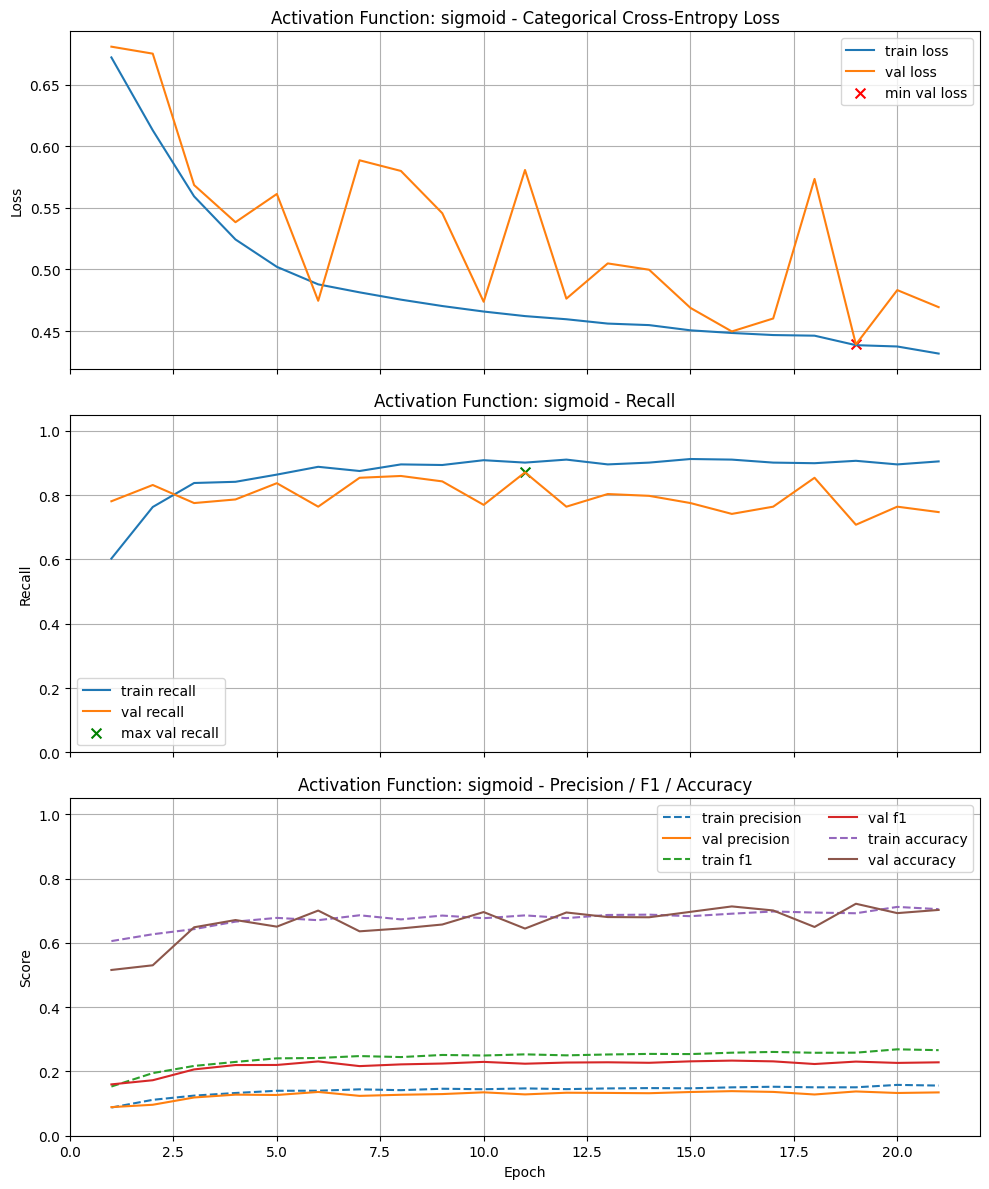


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


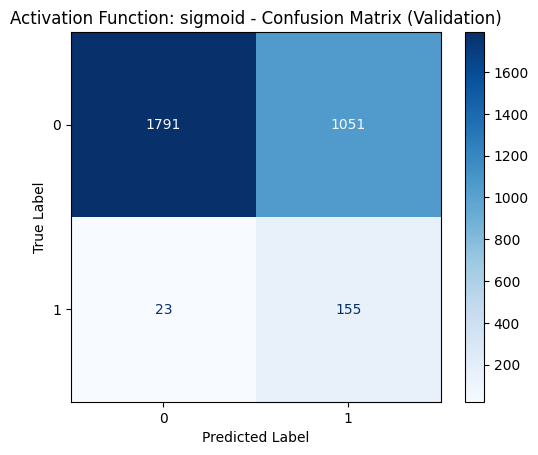

Final Training Metrics -> Loss: 0.4317, Precision: 0.1560, Recall: 0.9049, F1: 0.2661, Accuracy: 0.7047
Final Validation Metrics -> Loss: 0.4694, Precision: 0.1348, Recall: 0.7472, F1: 0.2283, Accuracy: 0.7023
Minimum Validation Loss: 0.4391 (Epoch 19)
Validation Metrics @ Min Loss -> Precision: 0.1377, Recall: 0.7079, F1: 0.2306, Accuracy: 0.7215
Best Validation Recall: 0.8708 (Epoch 11)
Best Validation Precision: 0.1387 (Epoch 16)
Best Validation F1: 0.2336 (Epoch 16)
Best Validation Accuracy: 0.7215 (Epoch 19)

Test Metrics -> Loss: 0.5848, Precision: 0.1289, Recall: 0.8876, F1: 0.2251, Accuracy: 0.6397

Validation-Test Gap -> Recall: 0.016854, Precision: 0.009781, F1: 0.008557, Accuracy: 0.081788

Execution Time: 00:00:05

Test Metrics -> Loss: 0.5848, Precision: 0.1289, Recall: 0.8876, F1: 0.2251, Accuracy: 0.6397

Validation-Test Gap -> Recall: 0.016854, Precision: 0.009781, F1: 0.008557, Accuracy: 0.081788

Execution Time: 00:00:05


In [12]:
# Your code here. Add as many cells as you need.
activation = ['relu', 'tanh', 'sigmoid']

results_1 = pd.DataFrame(columns=[
    'Title',
    'Best Val Recall',
    'Best Val Precision',
    'Best Val F1',
    'Best Val Accuracy',
    'Min Val Loss',
    'Val Recall @ Min Loss',
    'Val Precision @ Min Loss',
    'Val F1 @ Min Loss',
    'Test Recall',
    'Test Precision',
    'Test F1',
    'Test Accuracy'
], index=[0,1,2])

for i, func in enumerate(activation):
    model = build_model(X_train.shape[1], [ (64, func, 0.0, 0.0), (32, func, 0.0, 0.0)], n_classes)
    history, metrics = train_and_test(model, title=f"Activation Function: {func}", verbose=0, return_history = True)
    results_1.loc[i] = [
        f"Activation Function: {func}",
        metrics['best_val_recall'],
        metrics['best_val_precision'],
        metrics['best_val_f1'],
        metrics['best_val_accuracy'],
        metrics['min_val_loss'],
        metrics['val_recall_at_min_loss'],
        metrics['val_precision_at_min_loss'],
        metrics['val_f1_at_min_loss'],
        metrics['test_recall'],
        metrics['test_precision'],
        metrics['test_f1'],
        metrics['test_accuracy']
    ]

In [13]:
results_1

,Title,Best Val Recall,Best Val Precision,Best Val F1,Best Val Accuracy,Min Val Loss,Val Recall @ Min Loss,Val Precision @ Min Loss,Val F1 @ Min Loss,Test Recall,Test Precision,Test F1,Test Accuracy
0,Activation Function: relu,0.764045,0.155894,0.241263,0.821192,0.389729,0.460674,0.155894,0.232955,0.735955,0.130348,0.221471,0.695033
1,Activation Function: tanh,0.825843,0.148905,0.24076,0.796358,0.408469,0.44382,0.132773,0.204398,0.837079,0.12521,0.217836,0.645695
2,Activation Function: sigmoid,0.870786,0.138655,0.233628,0.721523,0.439116,0.707865,0.137705,0.230558,0.88764,0.128874,0.225071,0.639735


### Learning Rate Testing


Learning Rate: 0.001


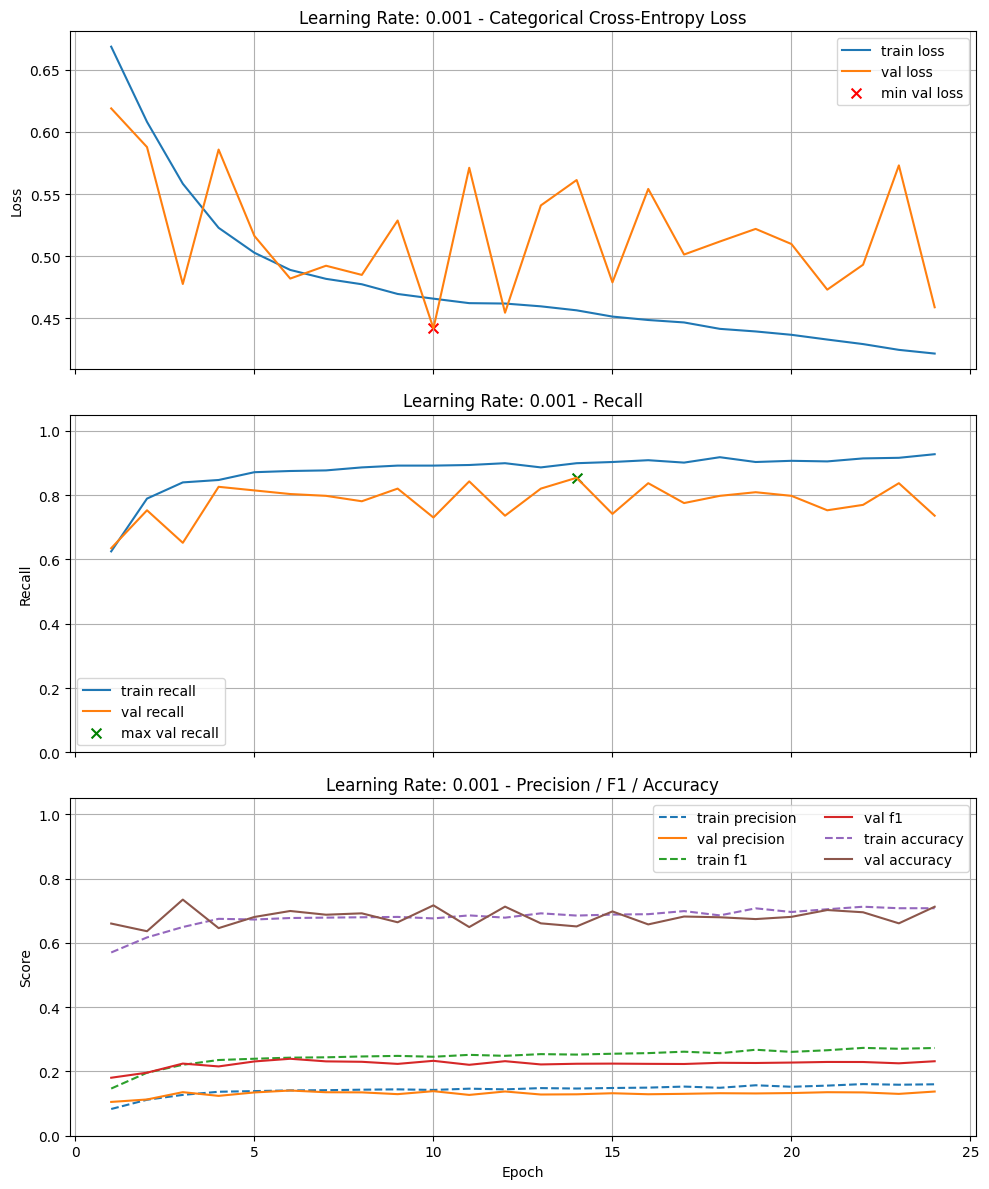


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


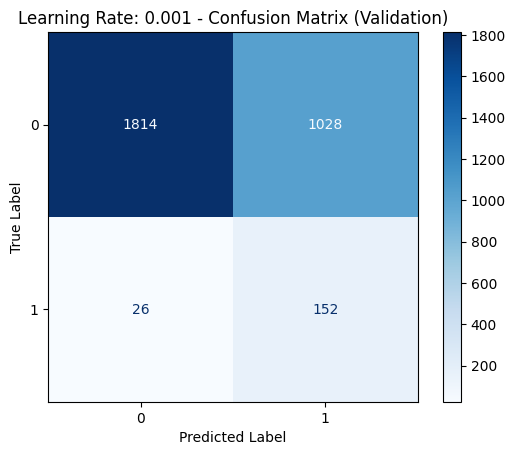

Final Training Metrics -> Loss: 0.4216, Precision: 0.1600, Recall: 0.9272, F1: 0.2729, Accuracy: 0.7076
Final Validation Metrics -> Loss: 0.4589, Precision: 0.1375, Recall: 0.7360, F1: 0.2317, Accuracy: 0.7123
Minimum Validation Loss: 0.4418 (Epoch 10)
Validation Metrics @ Min Loss -> Precision: 0.1386, Recall: 0.7303, F1: 0.2330, Accuracy: 0.7166
Best Validation Recall: 0.8539 (Epoch 14)
Best Validation Precision: 0.1406 (Epoch 6)
Best Validation F1: 0.2393 (Epoch 6)
Best Validation Accuracy: 0.7344 (Epoch 3)

Test Metrics -> Loss: 0.5646, Precision: 0.1316, Recall: 0.8764, F1: 0.2289, Accuracy: 0.6520

Validation-Test Gap -> Recall: 0.022472, Precision: 0.008964, F1: 0.010424, Accuracy: 0.082450

Execution Time: 00:00:05

Learning Rate: 0.0005


Test Metrics -> Loss: 0.5646, Precision: 0.1316, Recall: 0.8764, F1: 0.2289, Accuracy: 0.6520

Validation-Test Gap -> Recall: 0.022472, Precision: 0.008964, F1: 0.010424, Accuracy: 0.082450

Execution Time: 00:00:05

Learning Rate: 0.0005



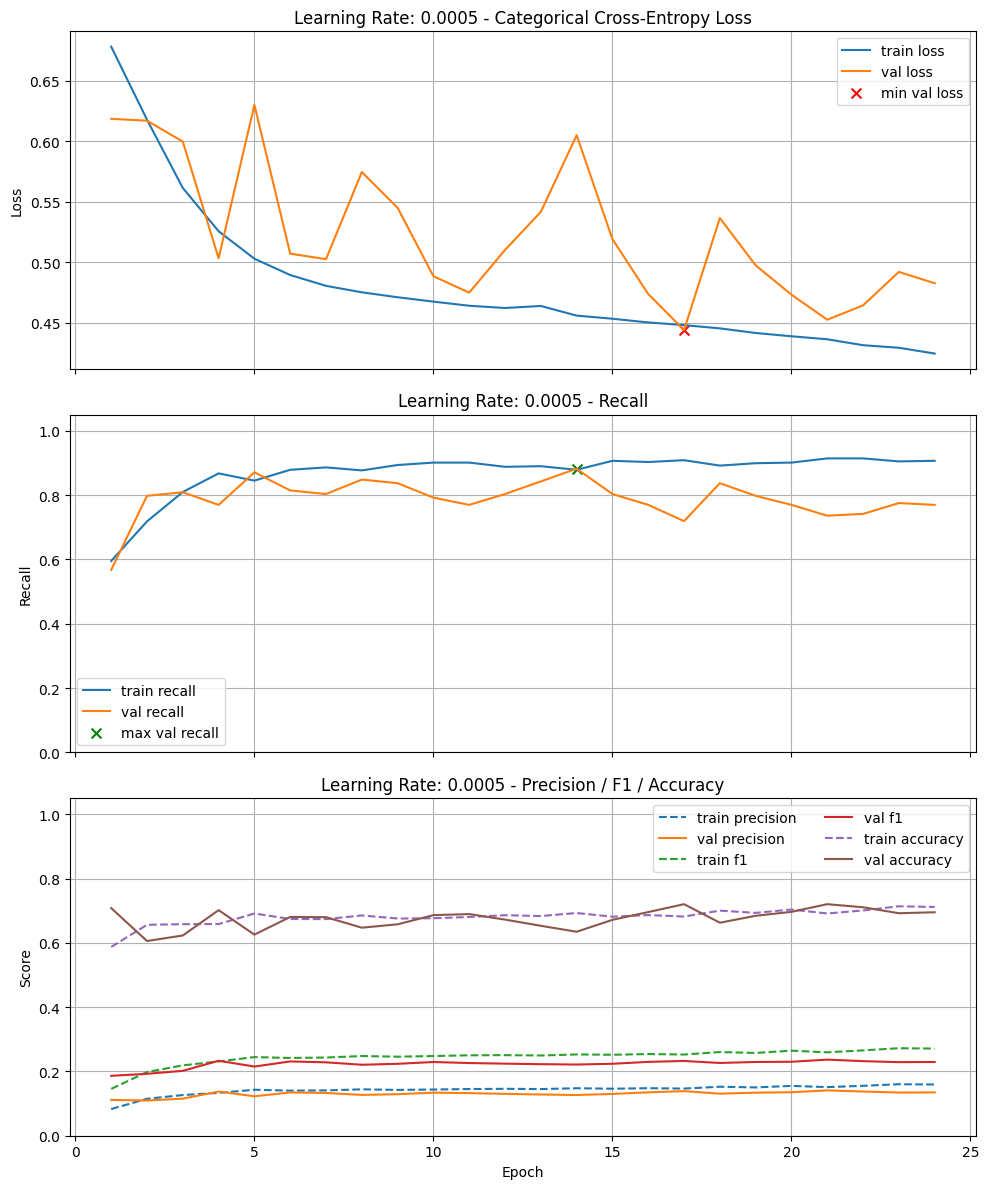


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step


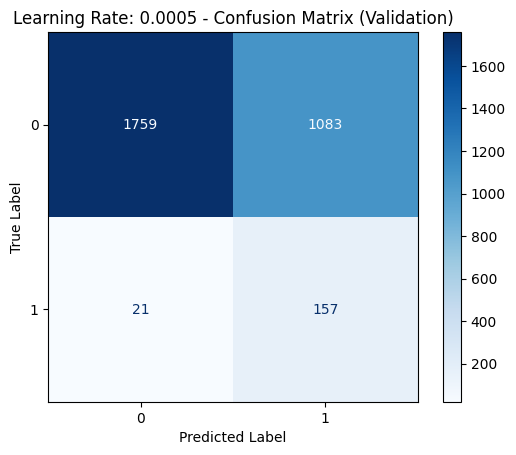

Final Training Metrics -> Loss: 0.4248, Precision: 0.1593, Recall: 0.9067, F1: 0.2711, Accuracy: 0.7115
Final Validation Metrics -> Loss: 0.4828, Precision: 0.1347, Recall: 0.7697, F1: 0.2293, Accuracy: 0.6950
Minimum Validation Loss: 0.4442 (Epoch 17)
Validation Metrics @ Min Loss -> Precision: 0.1387, Recall: 0.7191, F1: 0.2325, Accuracy: 0.7202
Best Validation Recall: 0.8820 (Epoch 14)
Best Validation Precision: 0.1410 (Epoch 21)
Best Validation F1: 0.2367 (Epoch 21)
Best Validation Accuracy: 0.7202 (Epoch 17)

Test Metrics -> Loss: 0.6081, Precision: 0.1292, Recall: 0.9045, F1: 0.2261, Accuracy: 0.6351

Validation-Test Gap -> Recall: 0.022472, Precision: 0.011798, F1: 0.010552, Accuracy: 0.085099

Execution Time: 00:00:05

Learning Rate: 0.0001


Test Metrics -> Loss: 0.6081, Precision: 0.1292, Recall: 0.9045, F1: 0.2261, Accuracy: 0.6351

Validation-Test Gap -> Recall: 0.022472, Precision: 0.011798, F1: 0.010552, Accuracy: 0.085099

Execution Time: 00:00:05

Learning Rate: 0.0001


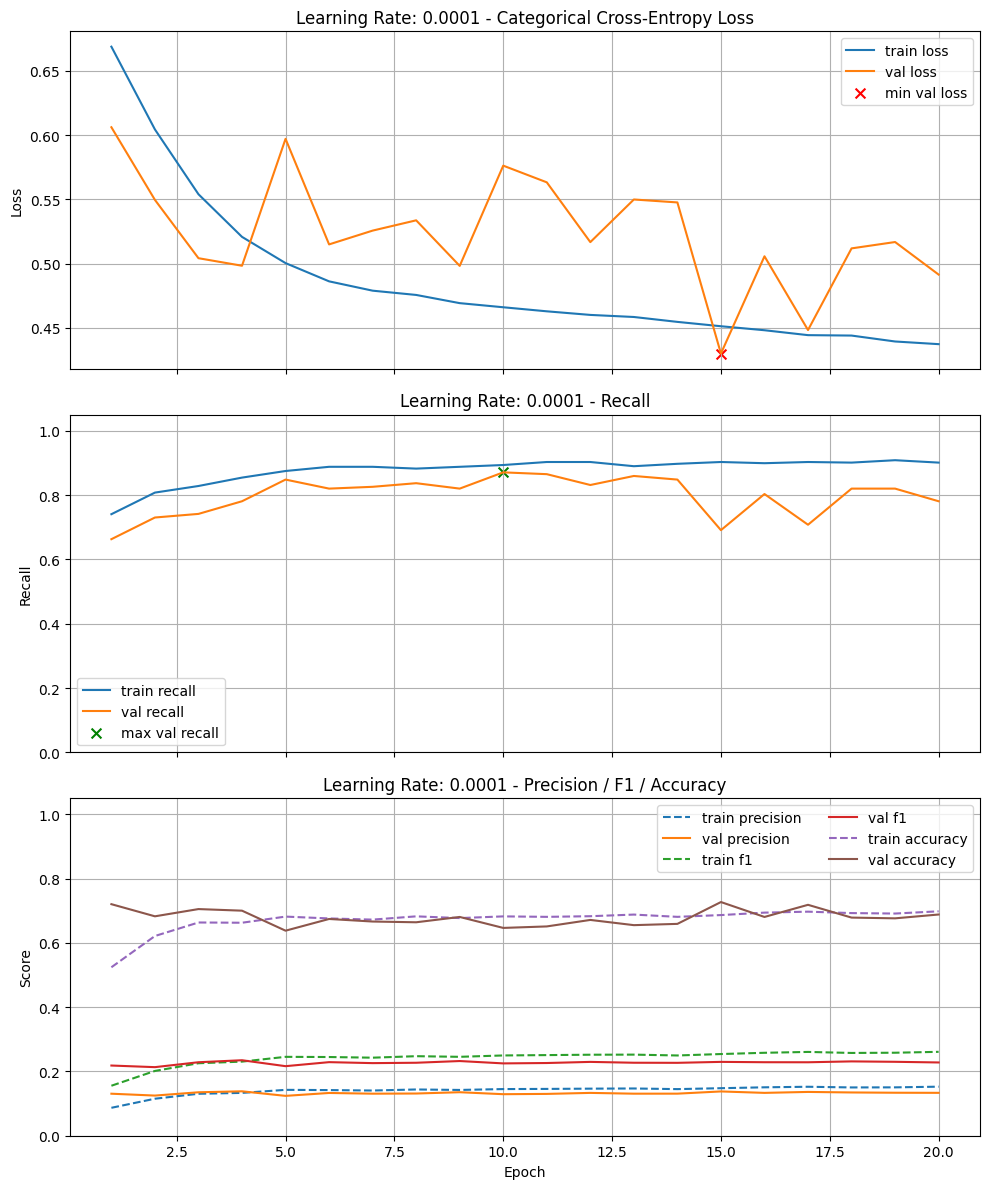


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


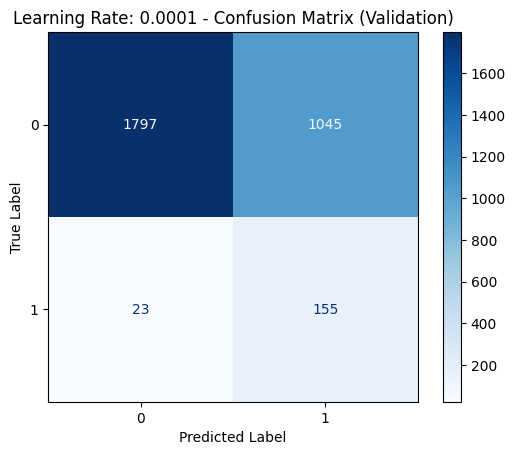

Final Training Metrics -> Loss: 0.4374, Precision: 0.1526, Recall: 0.9011, F1: 0.2609, Accuracy: 0.6980
Final Validation Metrics -> Loss: 0.4915, Precision: 0.1334, Recall: 0.7809, F1: 0.2279, Accuracy: 0.6881
Minimum Validation Loss: 0.4301 (Epoch 15)
Validation Metrics @ Min Loss -> Precision: 0.1377, Recall: 0.6910, F1: 0.2297, Accuracy: 0.7268
Best Validation Recall: 0.8708 (Epoch 10)
Best Validation Precision: 0.1382 (Epoch 4)
Best Validation F1: 0.2348 (Epoch 4)
Best Validation Accuracy: 0.7268 (Epoch 15)

Test Metrics -> Loss: 0.5811, Precision: 0.1276, Recall: 0.8708, F1: 0.2225, Accuracy: 0.6414

Validation-Test Gap -> Recall: 0.000000, Precision: 0.010599, F1: 0.012256, Accuracy: 0.085430

Execution Time: 00:00:04

Learning Rate: 5e-05


Test Metrics -> Loss: 0.5811, Precision: 0.1276, Recall: 0.8708, F1: 0.2225, Accuracy: 0.6414

Validation-Test Gap -> Recall: 0.000000, Precision: 0.010599, F1: 0.012256, Accuracy: 0.085430

Execution Time: 00:00:04

Learning Rate: 5e-05



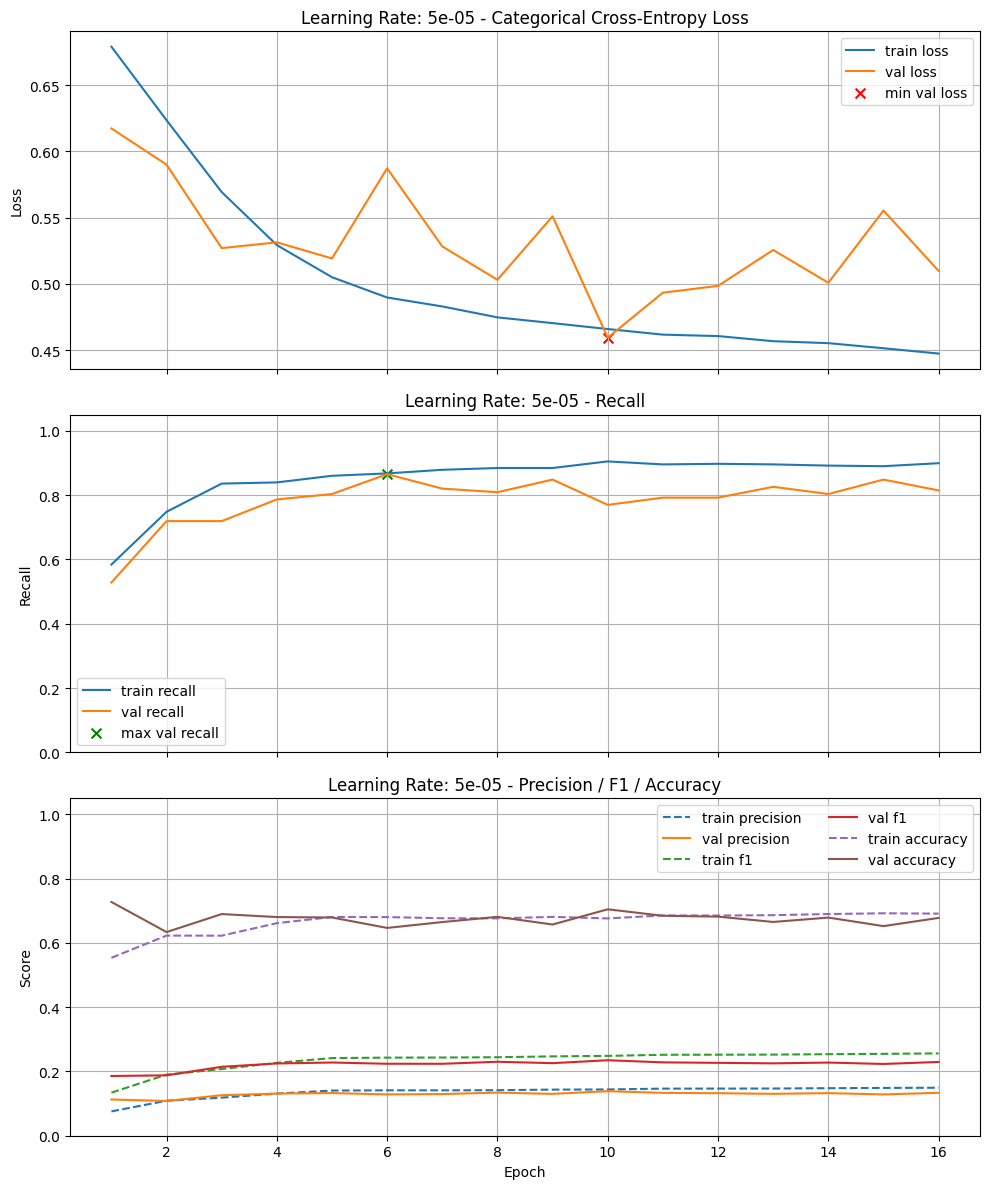


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


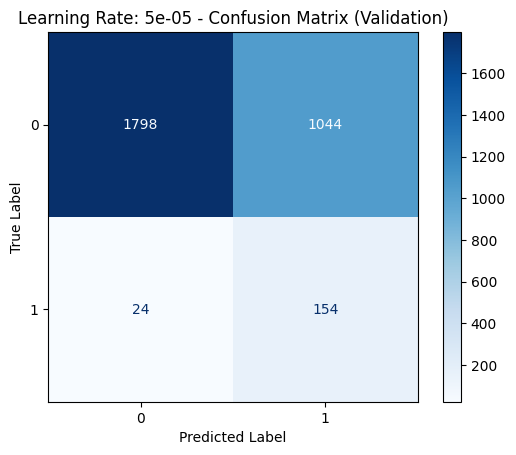

Final Training Metrics -> Loss: 0.4475, Precision: 0.1493, Recall: 0.8993, F1: 0.2560, Accuracy: 0.6908
Final Validation Metrics -> Loss: 0.5098, Precision: 0.1335, Recall: 0.8146, F1: 0.2294, Accuracy: 0.6775
Minimum Validation Loss: 0.4594 (Epoch 10)
Validation Metrics @ Min Loss -> Precision: 0.1385, Recall: 0.7697, F1: 0.2348, Accuracy: 0.7043
Best Validation Recall: 0.8652 (Epoch 6)
Best Validation Precision: 0.1385 (Epoch 10)
Best Validation F1: 0.2348 (Epoch 10)
Best Validation Accuracy: 0.7272 (Epoch 1)

Test Metrics -> Loss: 0.5973, Precision: 0.1296, Recall: 0.8820, F1: 0.2261, Accuracy: 0.6440

Validation-Test Gap -> Recall: 0.016854, Precision: 0.008879, F1: 0.008728, Accuracy: 0.083113

Execution Time: 00:00:04

Learning Rate: 1e-05


Test Metrics -> Loss: 0.5973, Precision: 0.1296, Recall: 0.8820, F1: 0.2261, Accuracy: 0.6440

Validation-Test Gap -> Recall: 0.016854, Precision: 0.008879, F1: 0.008728, Accuracy: 0.083113

Execution Time: 00:00:04

Learning Rate: 1e-05



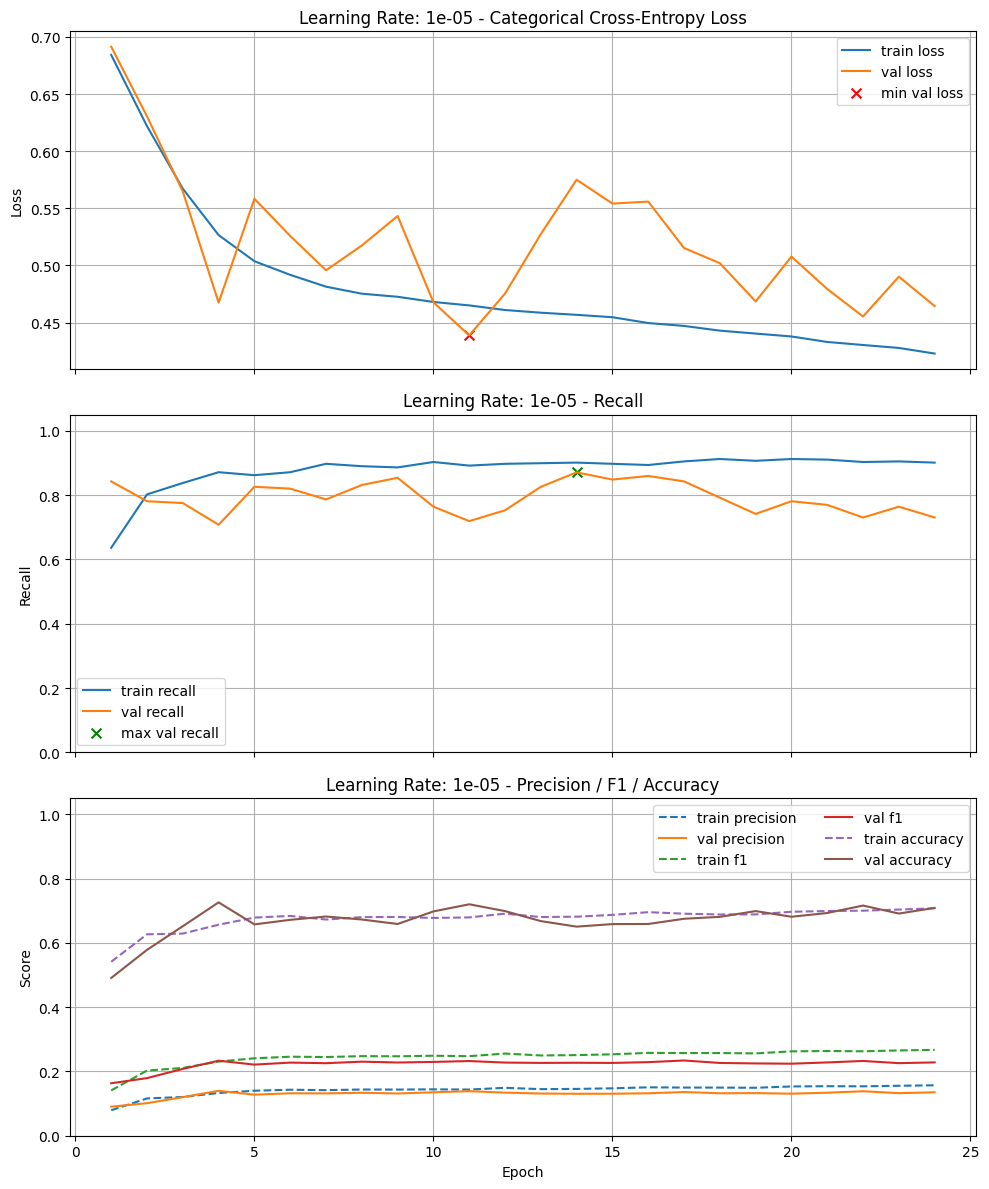


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


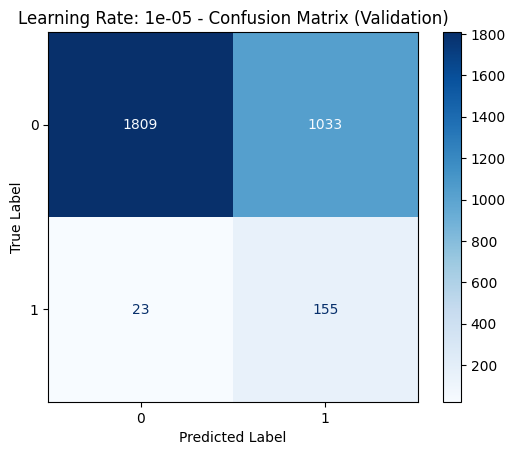

Final Training Metrics -> Loss: 0.4229, Precision: 0.1568, Recall: 0.9011, F1: 0.2671, Accuracy: 0.7075
Final Validation Metrics -> Loss: 0.4644, Precision: 0.1351, Recall: 0.7303, F1: 0.2281, Accuracy: 0.7086
Minimum Validation Loss: 0.4388 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.1385, Recall: 0.7191, F1: 0.2323, Accuracy: 0.7199
Best Validation Recall: 0.8708 (Epoch 14)
Best Validation Precision: 0.1397 (Epoch 4)
Best Validation F1: 0.2340 (Epoch 17)
Best Validation Accuracy: 0.7258 (Epoch 4)

Test Metrics -> Loss: 0.5788, Precision: 0.1314, Recall: 0.8820, F1: 0.2287, Accuracy: 0.6493

Validation-Test Gap -> Recall: 0.011236, Precision: 0.008309, F1: 0.005313, Accuracy: 0.076490

Execution Time: 00:00:05

Test Metrics -> Loss: 0.5788, Precision: 0.1314, Recall: 0.8820, F1: 0.2287, Accuracy: 0.6493

Validation-Test Gap -> Recall: 0.011236, Precision: 0.008309, F1: 0.005313, Accuracy: 0.076490

Execution Time: 00:00:05


In [14]:
# Your code here. Add as many cells as you need.
af = 'sigmoid'
learning_rate = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

results_2 = pd.DataFrame(columns=[
    'Title',
    'Best Val Recall',
    'Best Val Precision',
    'Best Val F1',
    'Best Val Accuracy',
    'Min Val Loss',
    'Val Recall @ Min Loss',
    'Val Precision @ Min Loss',
    'Val F1 @ Min Loss',
    'Test Recall',
    'Test Precision',
    'Test F1',
    'Test Accuracy'
], index=[0,1,2,3,4])

for i, lr in enumerate(learning_rate):
    model = build_model(X_train.shape[1], [ (64, af, 0.0, 0.0), (32, af, 0.0, 0.0)], n_classes)
    history, metrics = train_and_test(model, title=f"Learning Rate: {lr}", verbose=0, return_history = True)
    results_2.loc[i] = [
        f"Learning Rate: {lr}",
        metrics['best_val_recall'],
        metrics['best_val_precision'],
        metrics['best_val_f1'],
        metrics['best_val_accuracy'],
        metrics['min_val_loss'],
        metrics['val_recall_at_min_loss'],
        metrics['val_precision_at_min_loss'],
        metrics['val_f1_at_min_loss'],
        metrics['test_recall'],
        metrics['test_precision'],
        metrics['test_f1'],
        metrics['test_accuracy']
    ]

In [15]:
results_2

,Title,Best Val Recall,Best Val Precision,Best Val F1,Best Val Accuracy,Min Val Loss,Val Recall @ Min Loss,Val Precision @ Min Loss,Val F1 @ Min Loss,Test Recall,Test Precision,Test F1,Test Accuracy
0,Learning Rate: 0.001,0.853933,0.14061,0.239331,0.734437,0.441817,0.730337,0.138593,0.232975,0.876405,0.131646,0.228907,0.651987
1,Learning Rate: 0.0005,0.882023,0.141012,0.236676,0.720199,0.444179,0.719101,0.138678,0.232516,0.904494,0.129213,0.226124,0.635099
2,Learning Rate: 0.0001,0.870786,0.138171,0.234797,0.726821,0.430107,0.691011,0.137738,0.229692,0.870786,0.127572,0.222541,0.641391
3,Learning Rate: 5e-05,0.865169,0.138524,0.23479,0.727152,0.459448,0.769663,0.138524,0.23479,0.882023,0.129645,0.226062,0.64404
4,Learning Rate: 1e-05,0.870786,0.13969,0.234009,0.725828,0.438776,0.719101,0.138528,0.232305,0.882023,0.131381,0.228696,0.649338


### Dropout Testing


Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.3



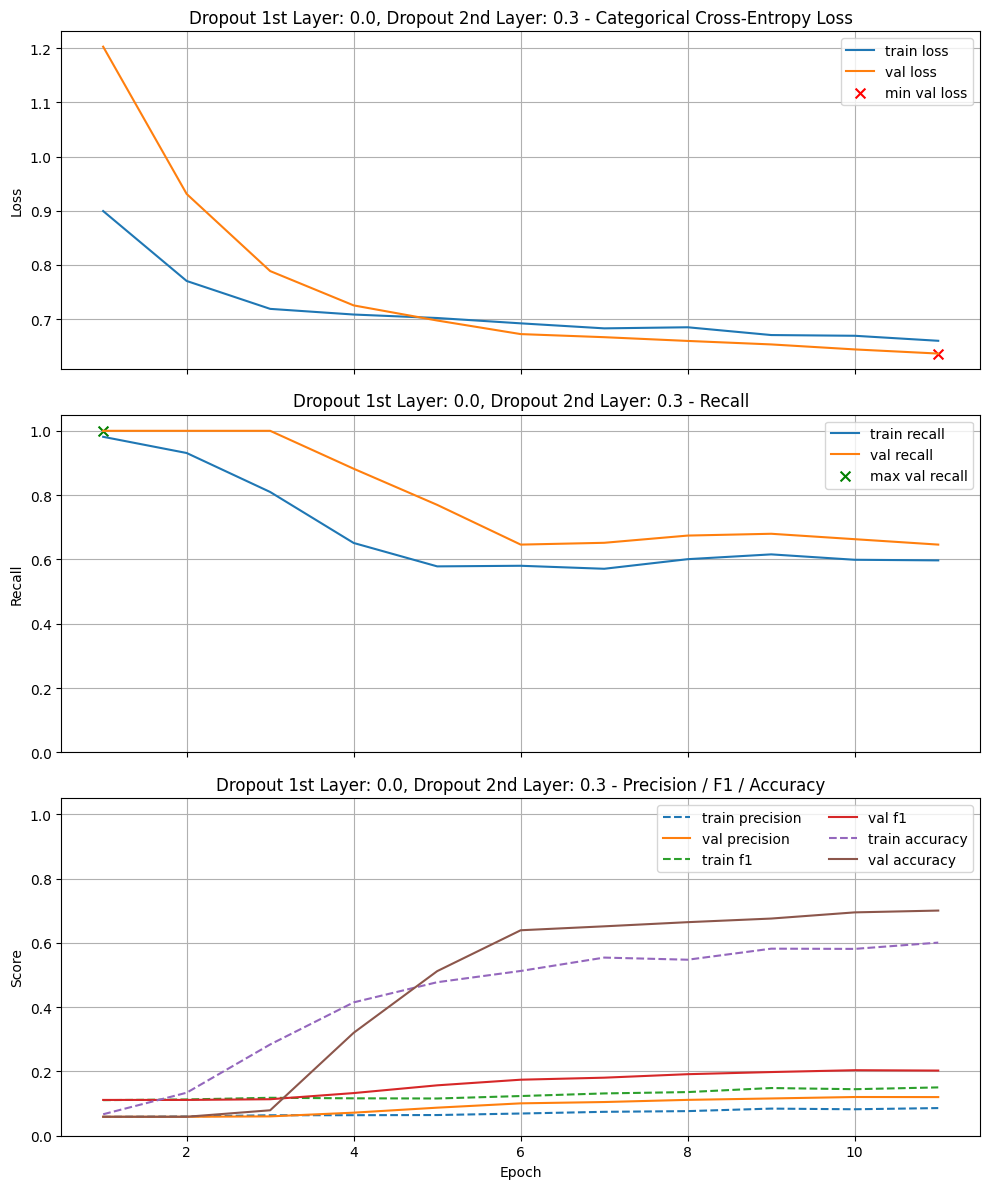


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


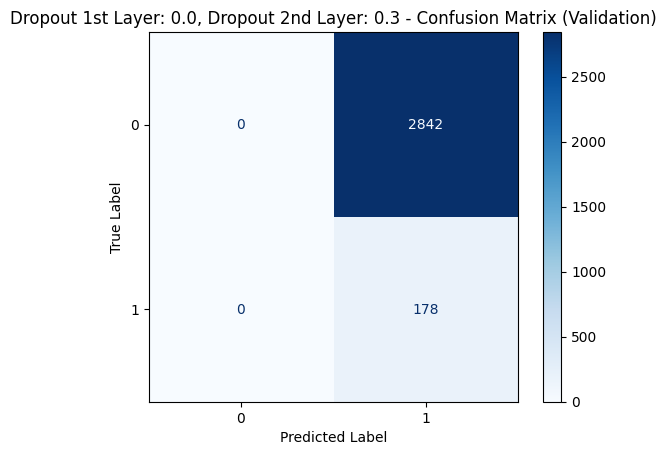

Final Training Metrics -> Loss: 0.6600, Precision: 0.0860, Recall: 0.5970, F1: 0.1503, Accuracy: 0.6007
Final Validation Metrics -> Loss: 0.6364, Precision: 0.1202, Recall: 0.6461, F1: 0.2026, Accuracy: 0.7003
Minimum Validation Loss: 0.6364 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.1202, Recall: 0.6461, F1: 0.2026, Accuracy: 0.7003
Best Validation Recall: 1.0000 (Epoch 1)
Best Validation Precision: 0.1204 (Epoch 10)
Best Validation F1: 0.2038 (Epoch 10)
Best Validation Accuracy: 0.7003 (Epoch 11)

Test Metrics -> Loss: 1.2022, Precision: 0.0589, Recall: 1.0000, F1: 0.1113, Accuracy: 0.0589

Validation-Test Gap -> Recall: 0.000000, Precision: 0.061468, F1: 0.092480, Accuracy: 0.641391

Execution Time: 00:00:03

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.4


Test Metrics -> Loss: 1.2022, Precision: 0.0589, Recall: 1.0000, F1: 0.1113, Accuracy: 0.0589

Validation-Test Gap -> Recall: 0.000000, Precision: 0.061468, F1: 0.092480, Accuracy: 0.641391

Execution Time: 00:00:03

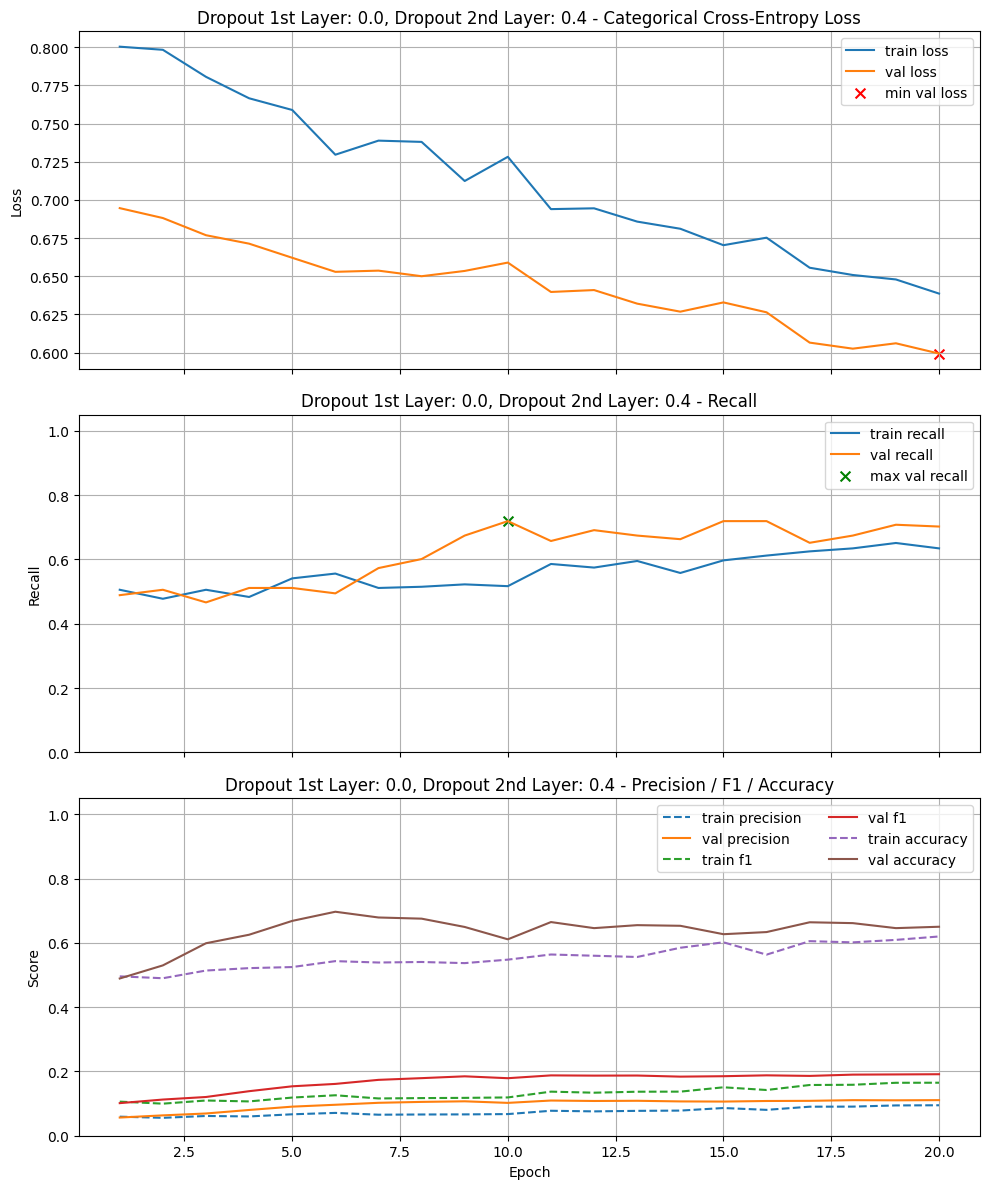


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


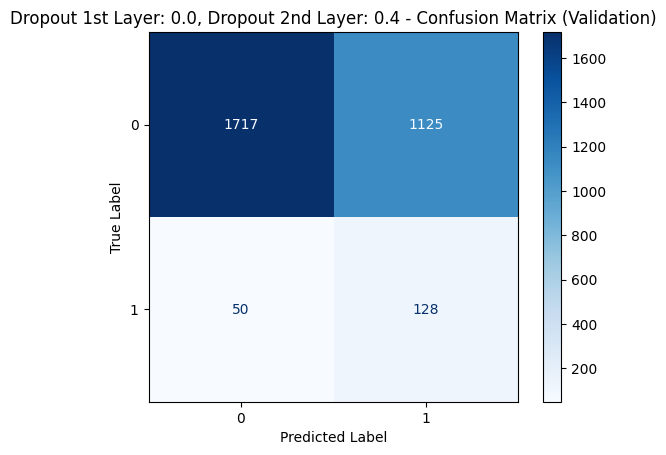

Final Training Metrics -> Loss: 0.6386, Precision: 0.0947, Recall: 0.6343, F1: 0.1648, Accuracy: 0.6198
Final Validation Metrics -> Loss: 0.5993, Precision: 0.1107, Recall: 0.7022, F1: 0.1913, Accuracy: 0.6500
Minimum Validation Loss: 0.5993 (Epoch 20)
Validation Metrics @ Min Loss -> Precision: 0.1107, Recall: 0.7022, F1: 0.1913, Accuracy: 0.6500
Best Validation Recall: 0.7191 (Epoch 10)
Best Validation Precision: 0.1107 (Epoch 20)
Best Validation F1: 0.1913 (Epoch 20)
Best Validation Accuracy: 0.6967 (Epoch 6)

Test Metrics -> Loss: 0.6613, Precision: 0.1023, Recall: 0.7416, F1: 0.1798, Accuracy: 0.6013

Validation-Test Gap -> Recall: 0.022472, Precision: 0.008392, F1: 0.011441, Accuracy: 0.095364

Execution Time: 00:00:05

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.5


Test Metrics -> Loss: 0.6613, Precision: 0.1023, Recall: 0.7416, F1: 0.1798, Accuracy: 0.6013

Validation-Test Gap -> Recall: 0.022472, Precision: 0.008392, F1: 0.011441, Accuracy: 0.095364

Execution Time: 00:00:05

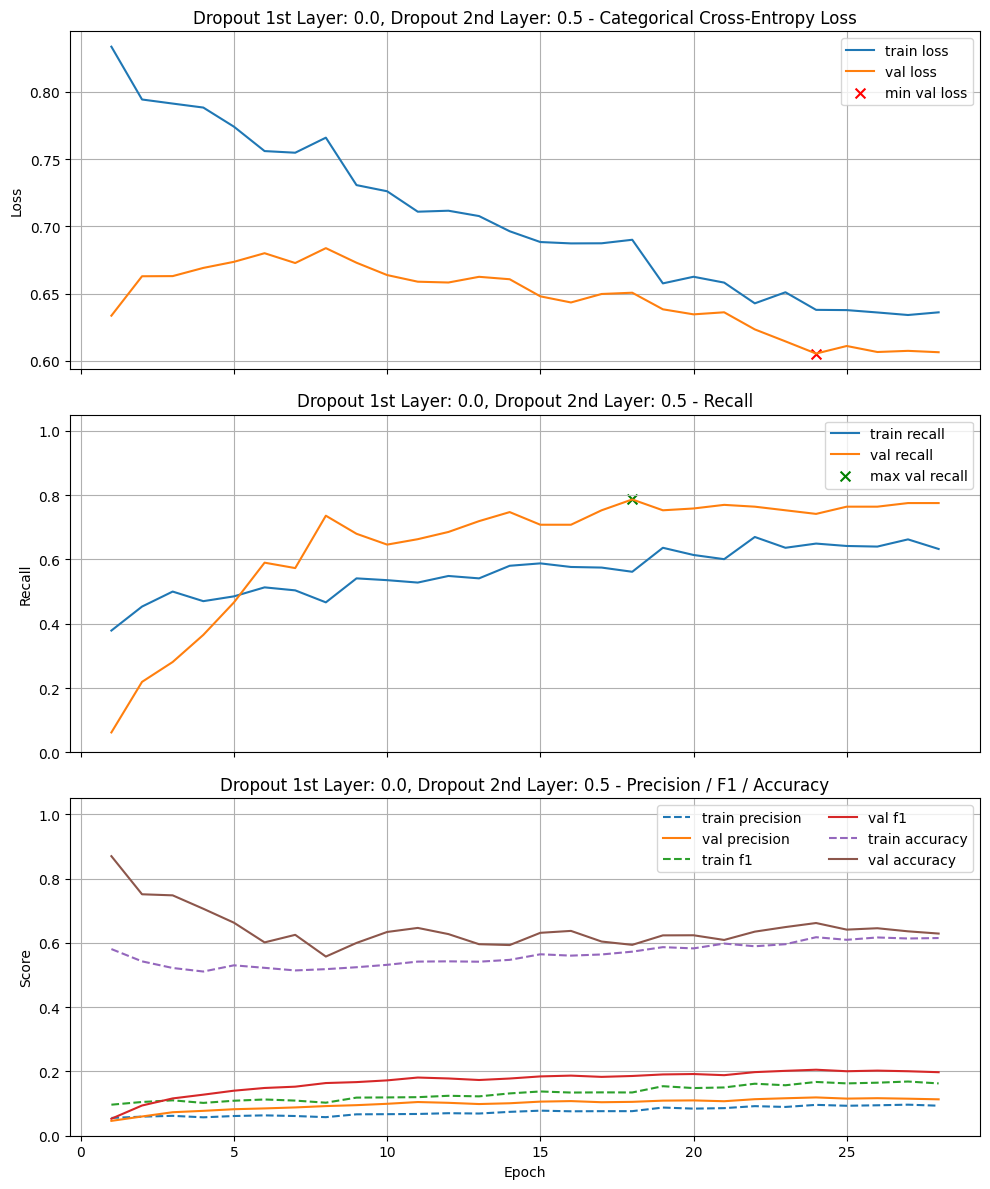


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step


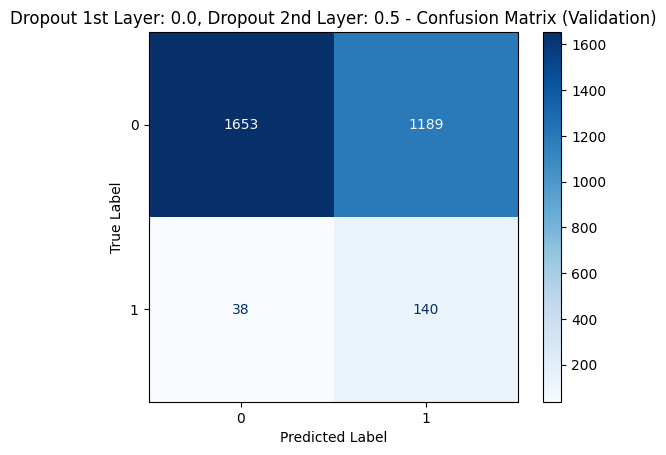

Final Training Metrics -> Loss: 0.6361, Precision: 0.0934, Recall: 0.6325, F1: 0.1627, Accuracy: 0.6149
Final Validation Metrics -> Loss: 0.6065, Precision: 0.1132, Recall: 0.7753, F1: 0.1976, Accuracy: 0.6288
Minimum Validation Loss: 0.6055 (Epoch 24)
Validation Metrics @ Min Loss -> Precision: 0.1191, Recall: 0.7416, F1: 0.2053, Accuracy: 0.6616
Best Validation Recall: 0.7865 (Epoch 18)
Best Validation Precision: 0.1191 (Epoch 24)
Best Validation F1: 0.2053 (Epoch 24)
Best Validation Accuracy: 0.8695 (Epoch 1)

Test Metrics -> Loss: 0.6509, Precision: 0.1184, Recall: 0.8933, F1: 0.2091, Accuracy: 0.6017

Validation-Test Gap -> Recall: 0.106742, Precision: 0.000742, F1: 0.003785, Accuracy: 0.267881

Execution Time: 00:00:06

Test Metrics -> Loss: 0.6509, Precision: 0.1184, Recall: 0.8933, F1: 0.2091, Accuracy: 0.6017

Validation-Test Gap -> Recall: 0.106742, Precision: 0.000742, F1: 0.003785, Accuracy: 0.267881

Execution Time: 00:00:06

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.3


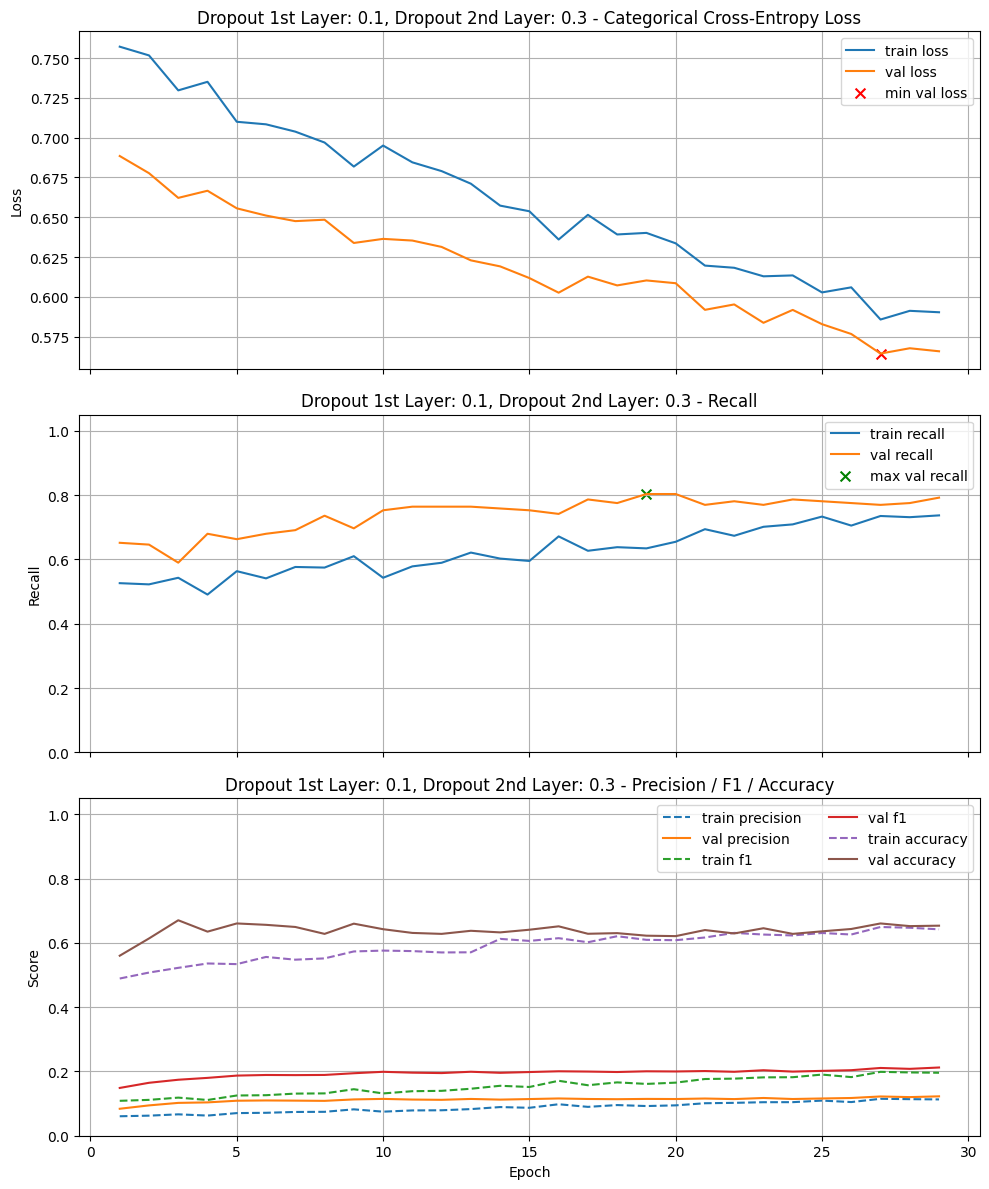


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


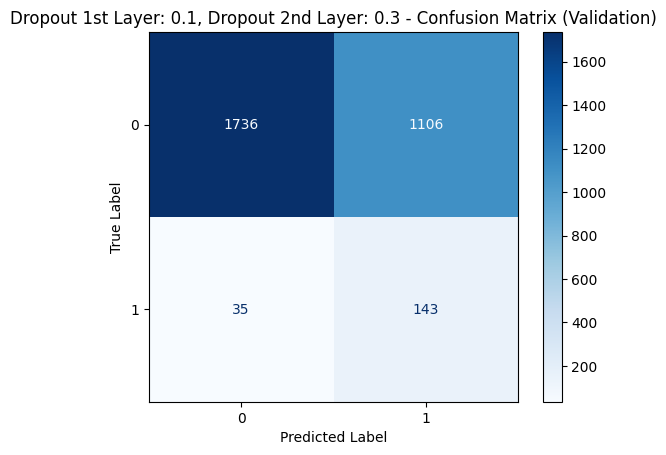

Final Training Metrics -> Loss: 0.5903, Precision: 0.1129, Recall: 0.7369, F1: 0.1958, Accuracy: 0.6419
Final Validation Metrics -> Loss: 0.5658, Precision: 0.1225, Recall: 0.7921, F1: 0.2122, Accuracy: 0.6533
Minimum Validation Loss: 0.5643 (Epoch 27)
Validation Metrics @ Min Loss -> Precision: 0.1221, Recall: 0.7697, F1: 0.2108, Accuracy: 0.6603
Best Validation Recall: 0.8034 (Epoch 19)
Best Validation Precision: 0.1225 (Epoch 29)
Best Validation F1: 0.2122 (Epoch 29)
Best Validation Accuracy: 0.6702 (Epoch 3)

Test Metrics -> Loss: 0.6157, Precision: 0.1117, Recall: 0.8090, F1: 0.1963, Accuracy: 0.6096

Validation-Test Gap -> Recall: 0.005618, Precision: 0.010788, F1: 0.015871, Accuracy: 0.060596

Execution Time: 00:00:06

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.4


Test Metrics -> Loss: 0.6157, Precision: 0.1117, Recall: 0.8090, F1: 0.1963, Accuracy: 0.6096

Validation-Test Gap -> Recall: 0.005618, Precision: 0.010788, F1: 0.015871, Accuracy: 0.060596

Execution Time: 00:00:06

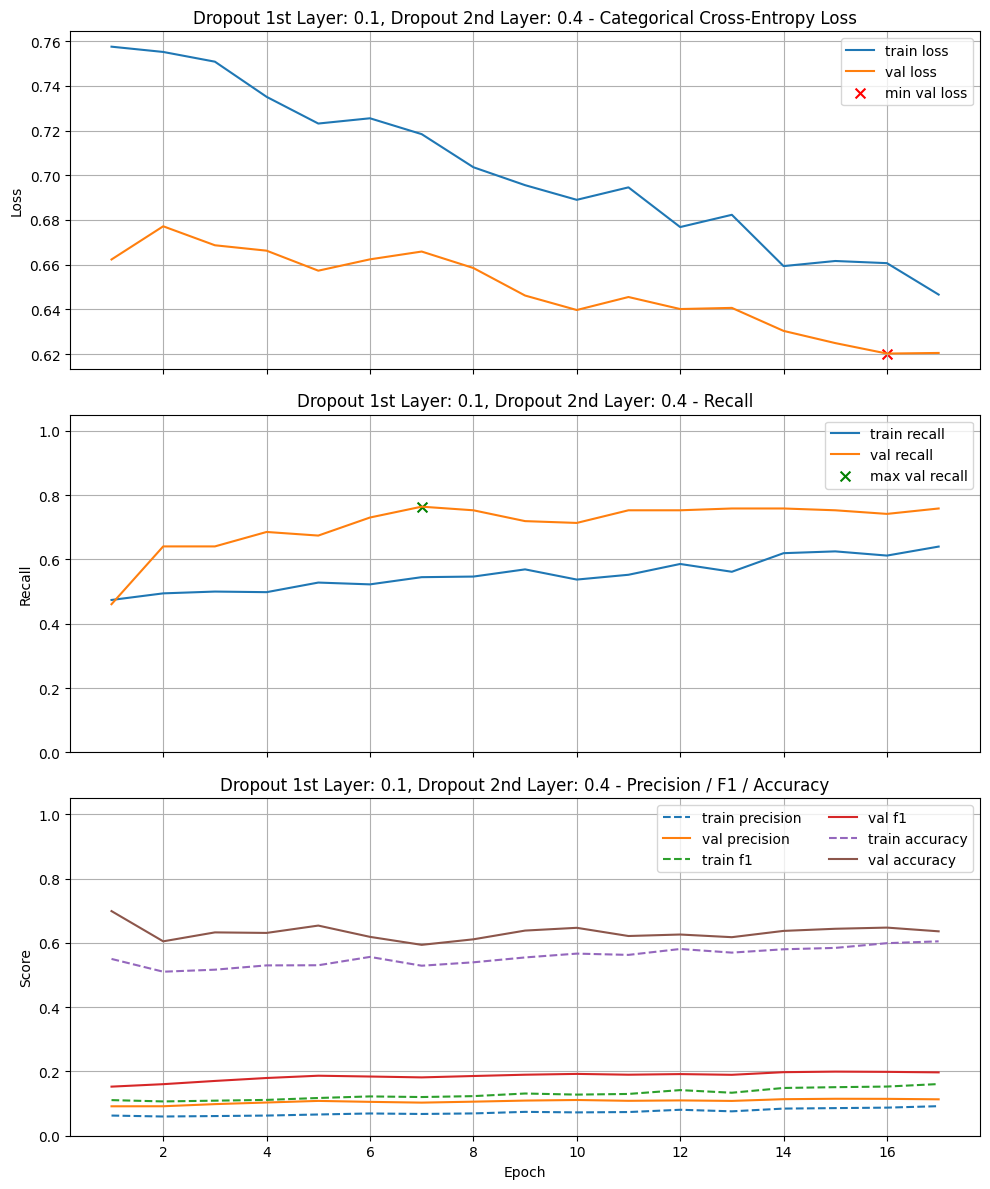


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step


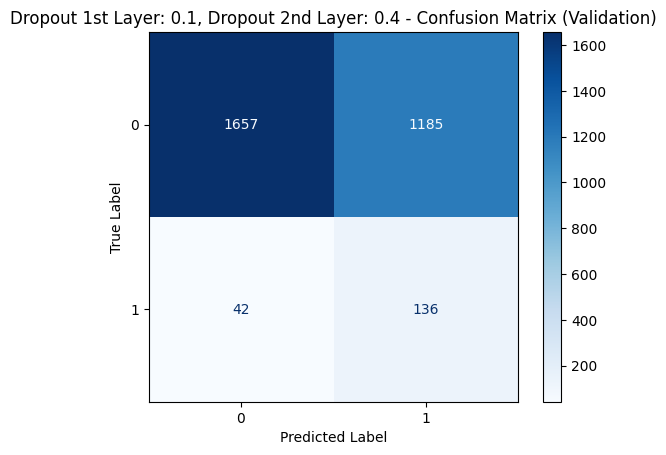

Final Training Metrics -> Loss: 0.6466, Precision: 0.0919, Recall: 0.6399, F1: 0.1607, Accuracy: 0.6046
Final Validation Metrics -> Loss: 0.6205, Precision: 0.1133, Recall: 0.7584, F1: 0.1971, Accuracy: 0.6358
Minimum Validation Loss: 0.6203 (Epoch 16)
Validation Metrics @ Min Loss -> Precision: 0.1147, Recall: 0.7416, F1: 0.1986, Accuracy: 0.6474
Best Validation Recall: 0.7640 (Epoch 7)
Best Validation Precision: 0.1149 (Epoch 15)
Best Validation F1: 0.1994 (Epoch 15)
Best Validation Accuracy: 0.6987 (Epoch 1)

Test Metrics -> Loss: 0.6669, Precision: 0.1090, Recall: 0.8202, F1: 0.1924, Accuracy: 0.5940

Validation-Test Gap -> Recall: 0.056180, Precision: 0.005968, F1: 0.007046, Accuracy: 0.104636

Execution Time: 00:00:05

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.5


Test Metrics -> Loss: 0.6669, Precision: 0.1090, Recall: 0.8202, F1: 0.1924, Accuracy: 0.5940

Validation-Test Gap -> Recall: 0.056180, Precision: 0.005968, F1: 0.007046, Accuracy: 0.104636

Execution Time: 00:00:05


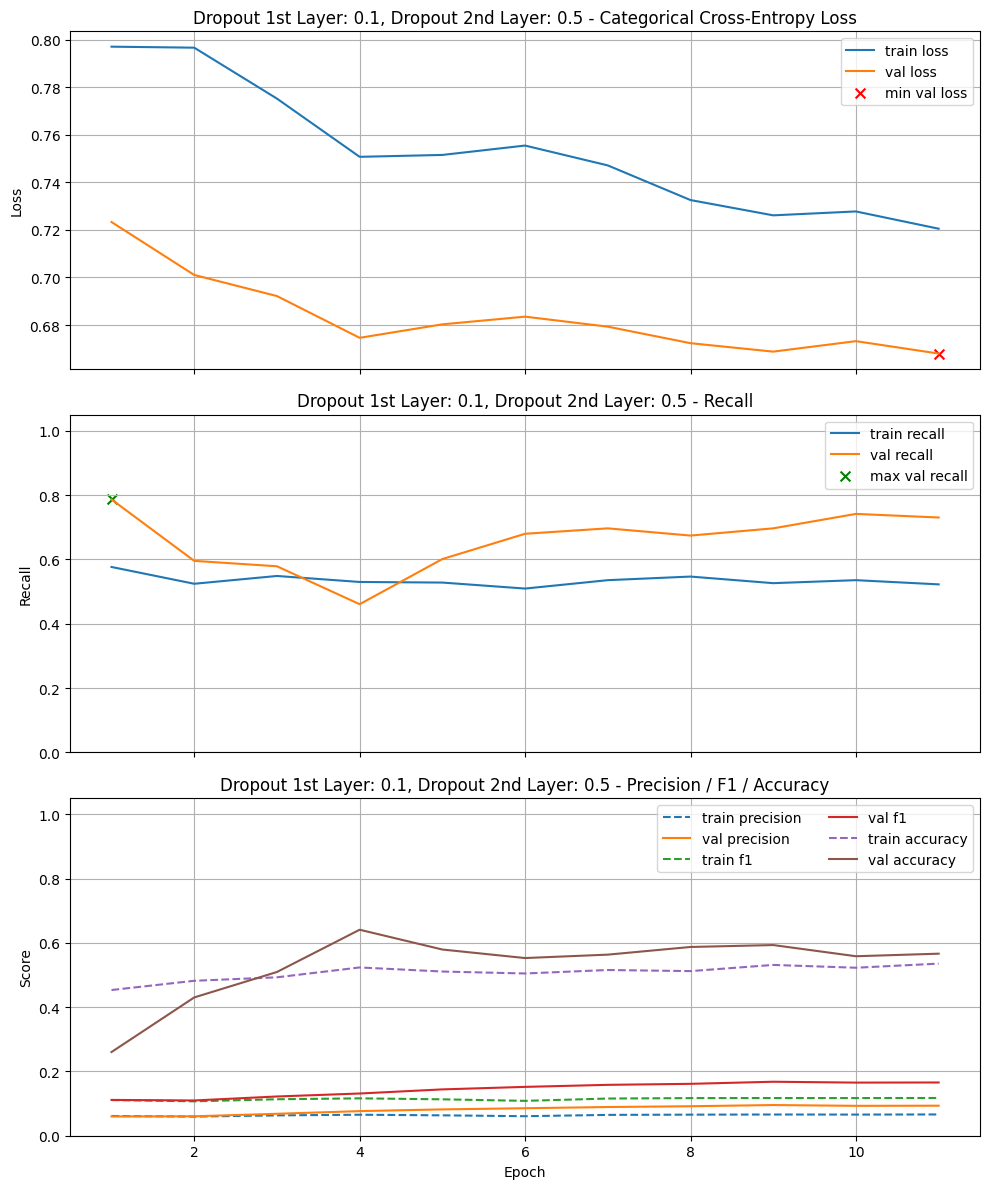


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


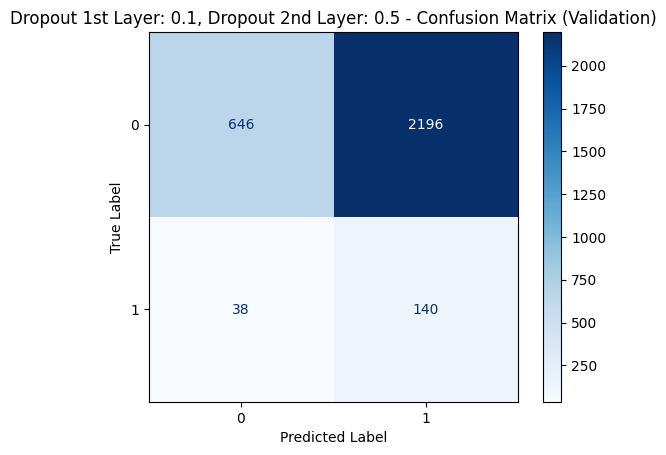

Final Training Metrics -> Loss: 0.7205, Precision: 0.0661, Recall: 0.5224, F1: 0.1174, Accuracy: 0.5353
Final Validation Metrics -> Loss: 0.6680, Precision: 0.0934, Recall: 0.7303, F1: 0.1656, Accuracy: 0.5662
Minimum Validation Loss: 0.6680 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.0934, Recall: 0.7303, F1: 0.1656, Accuracy: 0.5662
Best Validation Recall: 0.7865 (Epoch 1)
Best Validation Precision: 0.0955 (Epoch 9)
Best Validation F1: 0.1679 (Epoch 9)
Best Validation Accuracy: 0.6407 (Epoch 4)

Test Metrics -> Loss: 0.7232, Precision: 0.0593, Recall: 0.7865, F1: 0.1103, Accuracy: 0.2520

Validation-Test Gap -> Recall: 0.000000, Precision: 0.036161, F1: 0.057628, Accuracy: 0.388742

Execution Time: 00:00:03

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.3


Test Metrics -> Loss: 0.7232, Precision: 0.0593, Recall: 0.7865, F1: 0.1103, Accuracy: 0.2520

Validation-Test Gap -> Recall: 0.000000, Precision: 0.036161, F1: 0.057628, Accuracy: 0.388742

Execution Time: 00:00:03

D

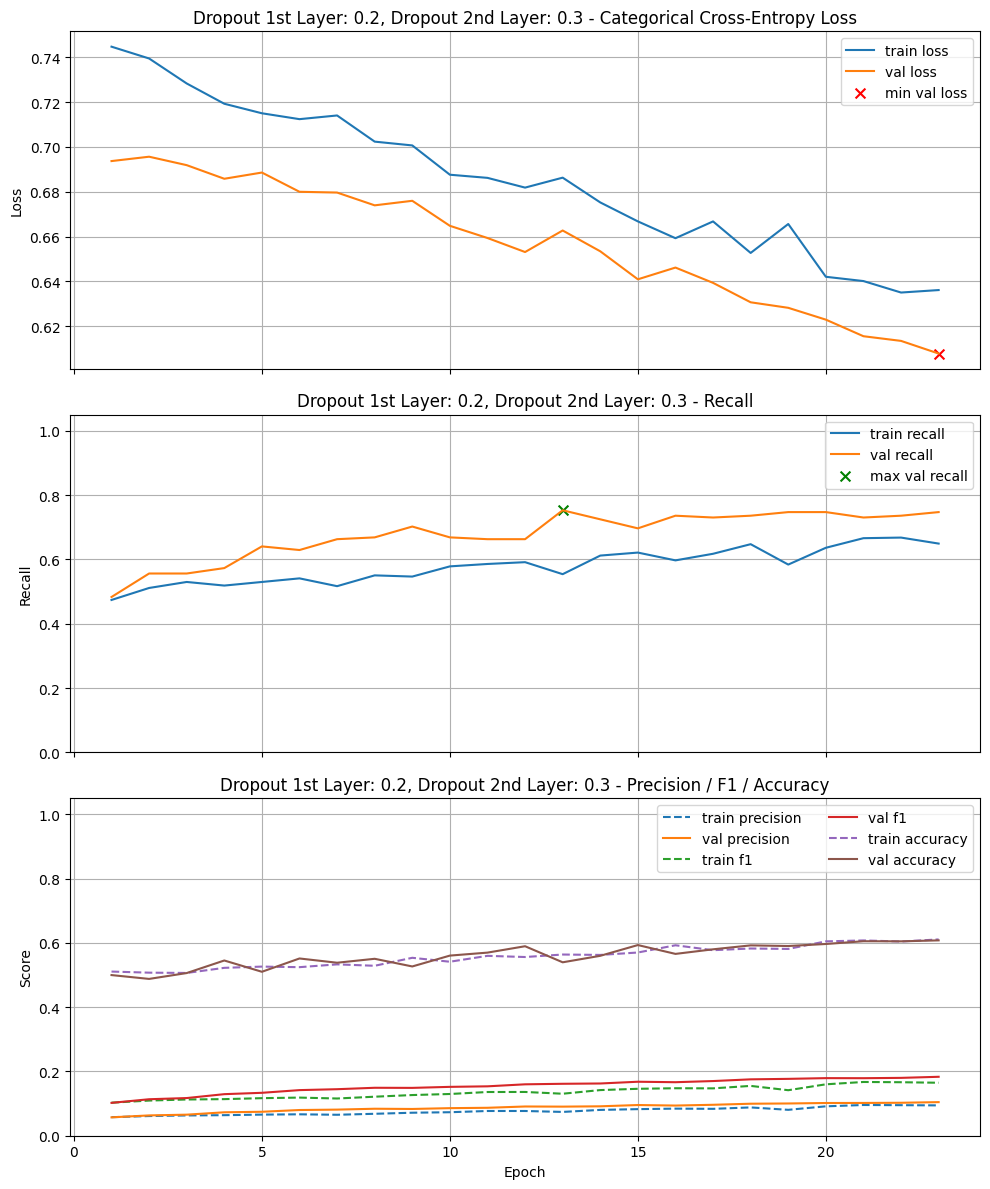


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


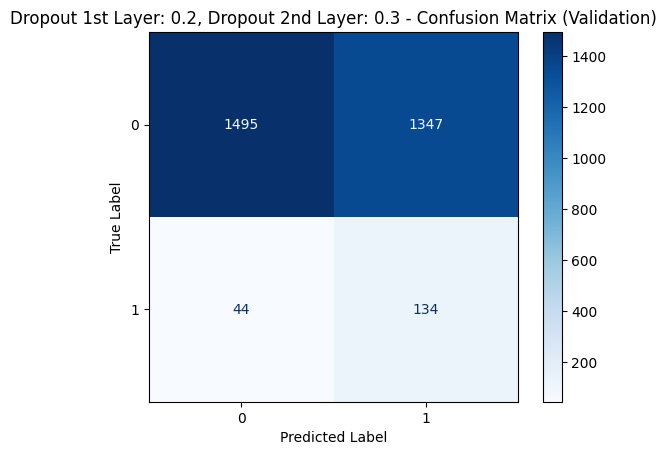

Final Training Metrics -> Loss: 0.6361, Precision: 0.0944, Recall: 0.6493, F1: 0.1648, Accuracy: 0.6106
Final Validation Metrics -> Loss: 0.6078, Precision: 0.1045, Recall: 0.7472, F1: 0.1833, Accuracy: 0.6076
Minimum Validation Loss: 0.6078 (Epoch 23)
Validation Metrics @ Min Loss -> Precision: 0.1045, Recall: 0.7472, F1: 0.1833, Accuracy: 0.6076
Best Validation Recall: 0.7528 (Epoch 13)
Best Validation Precision: 0.1045 (Epoch 23)
Best Validation F1: 0.1833 (Epoch 23)
Best Validation Accuracy: 0.6076 (Epoch 23)

Test Metrics -> Loss: 0.6641, Precision: 0.0975, Recall: 0.8258, F1: 0.1745, Accuracy: 0.5394

Validation-Test Gap -> Recall: 0.073034, Precision: 0.006933, F1: 0.008841, Accuracy: 0.068212

Execution Time: 00:00:05

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.4


Test Metrics -> Loss: 0.6641, Precision: 0.0975, Recall: 0.8258, F1: 0.1745, Accuracy: 0.5394

Validation-Test Gap -> Recall: 0.073034, Precision: 0.006933, F1: 0.008841, Accuracy: 0.068212

Execution Time: 00:00:0

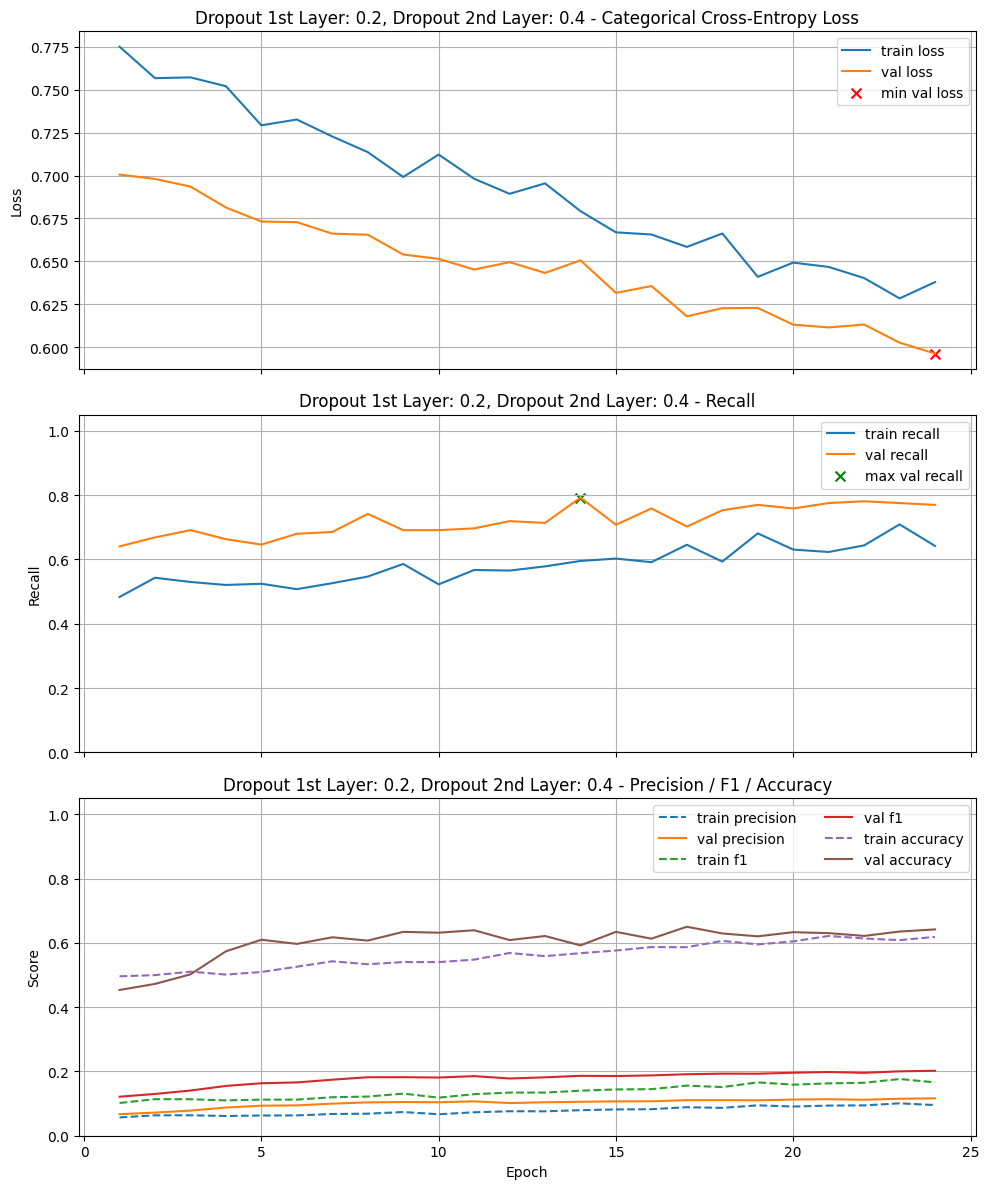


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


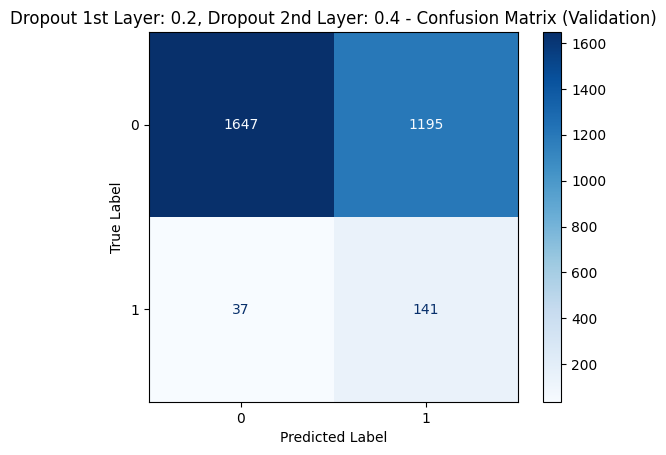

Final Training Metrics -> Loss: 0.6379, Precision: 0.0953, Recall: 0.6418, F1: 0.1660, Accuracy: 0.6184
Final Validation Metrics -> Loss: 0.5962, Precision: 0.1163, Recall: 0.7697, F1: 0.2021, Accuracy: 0.6417
Minimum Validation Loss: 0.5962 (Epoch 24)
Validation Metrics @ Min Loss -> Precision: 0.1163, Recall: 0.7697, F1: 0.2021, Accuracy: 0.6417
Best Validation Recall: 0.7921 (Epoch 14)
Best Validation Precision: 0.1163 (Epoch 24)
Best Validation F1: 0.2021 (Epoch 24)
Best Validation Accuracy: 0.6500 (Epoch 17)

Test Metrics -> Loss: 0.6510, Precision: 0.1106, Recall: 0.8427, F1: 0.1956, Accuracy: 0.5914

Validation-Test Gap -> Recall: 0.050562, Precision: 0.005679, F1: 0.006498, Accuracy: 0.058609

Execution Time: 00:00:06

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.5


Test Metrics -> Loss: 0.6510, Precision: 0.1106, Recall: 0.8427, F1: 0.1956, Accuracy: 0.5914

Validation-Test Gap -> Recall: 0.050562, Precision: 0.005679, F1: 0.006498, Accuracy: 0.058609

Execution Time: 00:00:0

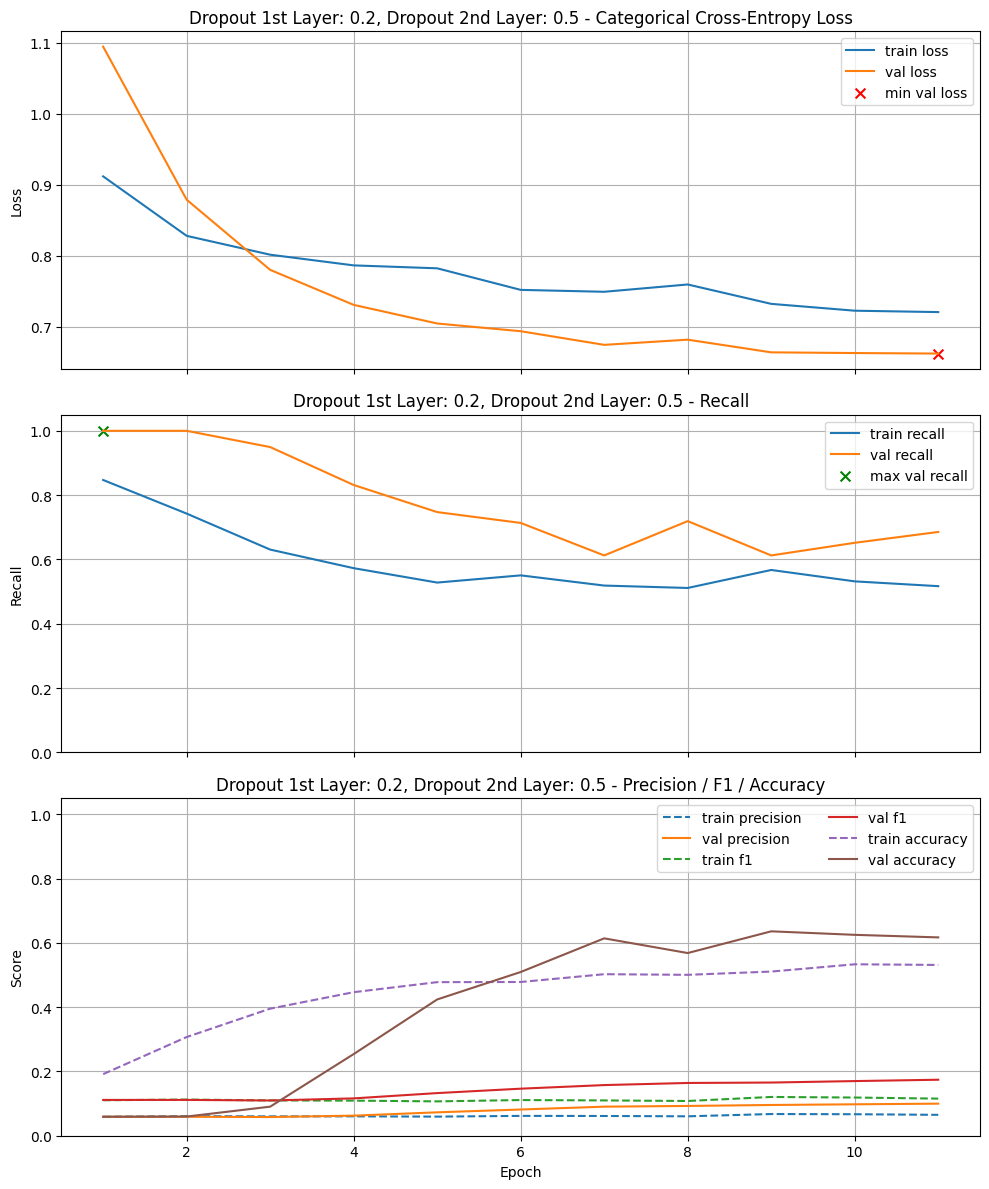


Confusion Matrix (Validation Set)
----------------------------------
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


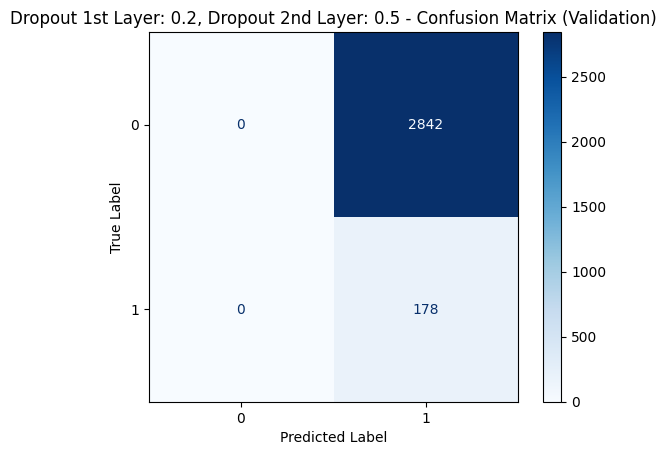

Final Training Metrics -> Loss: 0.7205, Precision: 0.0649, Recall: 0.5168, F1: 0.1154, Accuracy: 0.5312
Final Validation Metrics -> Loss: 0.6621, Precision: 0.0998, Recall: 0.6854, F1: 0.1742, Accuracy: 0.6169
Minimum Validation Loss: 0.6621 (Epoch 11)
Validation Metrics @ Min Loss -> Precision: 0.0998, Recall: 0.6854, F1: 0.1742, Accuracy: 0.6169
Best Validation Recall: 1.0000 (Epoch 1)
Best Validation Precision: 0.0998 (Epoch 11)
Best Validation F1: 0.1742 (Epoch 11)
Best Validation Accuracy: 0.6358 (Epoch 9)

Test Metrics -> Loss: 1.0959, Precision: 0.0589, Recall: 1.0000, F1: 0.1113, Accuracy: 0.0589

Validation-Test Gap -> Recall: 0.000000, Precision: 0.040814, F1: 0.062842, Accuracy: 0.576821

Execution Time: 00:00:03

Test Metrics -> Loss: 1.0959, Precision: 0.0589, Recall: 1.0000, F1: 0.1113, Accuracy: 0.0589

Validation-Test Gap -> Recall: 0.000000, Precision: 0.040814, F1: 0.062842, Accuracy: 0.576821

Execution Time: 00:00:03


In [16]:
# Your code here. Add as many cells as you need.
lr = 1e-4

drop_out_1st_layer = [0.0, 0.1, 0.2]
drop_out_2nd_layer = [0.3, 0.4, 0.5]

results_3 = pd.DataFrame(columns=[
    'Title',
    'Best Val Recall',
    'Best Val Precision',
    'Best Val F1',
    'Best Val Accuracy',
    'Min Val Loss',
    'Val Recall @ Min Loss',
    'Val Precision @ Min Loss',
    'Val F1 @ Min Loss',
    'Test Recall',
    'Test Precision',
    'Test F1',
    'Test Accuracy'
], index=[0,1,2,3,4,5,6,7,8])

for i, drop_out_1st in enumerate(drop_out_1st_layer):
    for j, drop_out_2nd in enumerate(drop_out_2nd_layer):
        model = build_model(X_train.shape[1], [ (64, af, 0.0, drop_out_1st), (32, af , 0.0, drop_out_2nd)], n_classes)
        history, metrics = train_and_test(model, lr_schedule=lr, title=f"Dropout 1st Layer: {drop_out_1st}, Dropout 2nd Layer: {drop_out_2nd}", verbose=0, return_history = True)
        results_3.iloc[i * 3 + j] = [
            f"Dropout 1st Layer: {drop_out_1st}, Dropout 2nd Layer: {drop_out_2nd}",
            metrics['best_val_recall'],
            metrics['best_val_precision'],
            metrics['best_val_f1'],
            metrics['best_val_accuracy'],
            metrics['min_val_loss'],
            metrics['val_recall_at_min_loss'],
            metrics['val_precision_at_min_loss'],
            metrics['val_f1_at_min_loss'],
            metrics['test_recall'],
            metrics['test_precision'],
            metrics['test_f1'],
            metrics['test_accuracy']
        ]

In [17]:
results_3

,Title,Best Val Recall,Best Val Precision,Best Val F1,Best Val Accuracy,Min Val Loss,Val Recall @ Min Loss,Val Precision @ Min Loss,Val F1 @ Min Loss,Test Recall,Test Precision,Test F1,Test Accuracy
0,"Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.3",1.0,0.120408,0.2038,0.700331,0.636439,0.646067,0.120167,0.202643,1.0,0.05894,0.11132,0.05894
1,"Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.4",0.719101,0.110717,0.191278,0.696689,0.599309,0.702247,0.110717,0.191278,0.741573,0.102326,0.179837,0.601324
2,"Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.5",0.786517,0.119134,0.205288,0.869536,0.605491,0.741573,0.119134,0.205288,0.893258,0.118392,0.209073,0.601656
3,"Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.3",0.803371,0.122502,0.21219,0.670199,0.56432,0.769663,0.122103,0.210769,0.808989,0.111715,0.196319,0.609603
4,"Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.4",0.764045,0.114923,0.199405,0.698676,0.620257,0.741573,0.114683,0.198646,0.820225,0.108955,0.192358,0.59404
5,"Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.5",0.786517,0.095458,0.167908,0.640728,0.668004,0.730337,0.093391,0.165605,0.786517,0.059297,0.11028,0.251987
6,"Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.3",0.752809,0.104478,0.183322,0.607616,0.607813,0.747191,0.104478,0.183322,0.825843,0.097545,0.174481,0.539404
7,"Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.4",0.792135,0.116299,0.202065,0.65,0.596195,0.769663,0.116299,0.202065,0.842697,0.110619,0.195567,0.591391
8,"Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.5",1.0,0.099755,0.174161,0.635762,0.662097,0.685393,0.099755,0.174161,1.0,0.05894,0.11132,0.05894


In [18]:
# Combine all results
results_all = pd.concat([results_1, results_2, results_3], axis=0).reset_index(drop=True)
results_all

,Title,Best Val Recall,Best Val Precision,Best Val F1,Best Val Accuracy,Min Val Loss,Val Recall @ Min Loss,Val Precision @ Min Loss,Val F1 @ Min Loss,Test Recall,Test Precision,Test F1,Test Accuracy
0,Activation Function: relu,0.764045,0.155894,0.241263,0.821192,0.389729,0.460674,0.155894,0.232955,0.735955,0.130348,0.221471,0.695033
1,Activation Function: tanh,0.825843,0.148905,0.24076,0.796358,0.408469,0.44382,0.132773,0.204398,0.837079,0.12521,0.217836,0.645695
2,Activation Function: sigmoid,0.870786,0.138655,0.233628,0.721523,0.439116,0.707865,0.137705,0.230558,0.88764,0.128874,0.225071,0.639735
3,Learning Rate: 0.001,0.853933,0.14061,0.239331,0.734437,0.441817,0.730337,0.138593,0.232975,0.876405,0.131646,0.228907,0.651987
4,Learning Rate: 0.0005,0.882023,0.141012,0.236676,0.720199,0.444179,0.719101,0.138678,0.232516,0.904494,0.129213,0.226124,0.635099
5,Learning Rate: 0.0001,0.870786,0.138171,0.234797,0.726821,0.430107,0.691011,0.137738,0.229692,0.870786,0.127572,0.222541,0.641391
6,Learning Rate: 5e-05,0.865169,0.138524,0.23479,0.727152,0.459448,0.769663,0.138524,0.23479,0.882023,0.129645,0.226062,0.64404
7,Learning Rate: 1e-05,0.870786,0.13969,0.234009,0.725828,0.438776,0.719101,0.138528,0.232305,0.882023,0.131381,0.228696,0.649338
8,"Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.3",1.0,0.120408,0.2038,0.700331,0.636439,0.646067,0.120167,0.202643,1.0,0.05894,0.11132,0.05894
9,"Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.4",0.719101,0.110717,0.191278,0.696689,0.599309,0.702247,0.110717,0.191278,0.741573,0.102326,0.179837,0.601324
